In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import deepwave
import torch.optim as optim
import itertools
import pandas as pd
from torch.utils.data import Subset

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

from seismiclip.bert import *
from seismiclip.vit import *
from seismiclip.clip import *
from seismiclip.plots import *
from seismiclip.utils import *
from seismiclip.storseismic import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parent_dir = "/home/randycm/Documents/Research/Projects/CLIPS/experiments"
parent_dir = os.path.join(parent_dir, "experiment_6")
if not os.path.exists(os.path.join(parent_dir)):
    os.mkdir(parent_dir)

/home/randycm/miniconda/envs/seismiclip/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def generate_gathers(vp_true, vs_true, rho_true):
        
    # Set parameters
    freq = 6
    dx = 24
    dz = 7
    dt = 0.002 # 1ms
    
    nt = int(4 / dt) # 6s
    num_dims = 2
    num_shots = 16 #259
    num_sources_per_shot = 1
    num_receivers_per_shot = 128 #256
    source_spacing = 159 #255.9 #255 #159 #30.0
    receiver_spacing = 19
    device = torch.device('cuda')
    
    vp_true = vp_true.float().to(device)
    vs_true = vs_true.float().to(device)
    rho_true = rho_true.float().to(device)

    source_locations = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    source_locations[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    source_locations[:, 0, 0] += dx
    receiver_locations = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    receiver_locations[:, :, 0] += dx
    receiver_locations[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    receiver_locations[:, :, 1] = receiver_locations[0, :, 1].repeat(num_shots, 1)

    source_locations = source_locations/10
    receiver_locations = receiver_locations/10

    source_amplitudes = (
        deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
        .repeat(num_shots, num_sources_per_shot, 1)
        .to(device)
    ).clone().to(device)

    # Propagate
    out = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true, rho_true),
        [dz, dx], dt, source_amplitudes_y=source_amplitudes.to(device),
        source_locations_y=source_locations.to(device),
        receiver_locations_y=receiver_locations.to(device),
        accuracy=4,
        pml_freq=freq,
        pml_width=[50, 50, 50, 50]
    )[-2]
    receiver_amplitudes_true = out #+ 2e-9*torch.randn_like(out)
    
    return receiver_amplitudes_true.detach().cpu().numpy()

# Define the seismic encoder model

## BERT Data

In [8]:
# # Clip values
# bert_data = torch.from_numpy(data_edited/abs(data_edited).max()).float().view(-1,data_edited.shape[-2],data_edited.shape[-1])

# generate_data = False

# if generate_data:
    
#     train_mlm, test_mlm = {}, {}

#     split_idx = int(0.2*bert_data.shape[0])
#     set_seed(12315019)
#     randn_idx = random.sample(range(0,bert_data.shape[0]),bert_data.shape[0])
    
#     train_idx = randn_idx[split_idx:]
#     test_idx = randn_idx[:split_idx]

#     train_mlm['inputs_embeds'] = bert_data[train_idx].detach().clone()
#     train_mlm['labels'] =  bert_data[train_idx].detach().clone()
#     train_mlm['mask_label'] = torch.zeros_like(bert_data[train_idx].detach().clone())
#     train_mlm['index'] = torch.arange(bert_data[train_idx].shape[0])

#     test_mlm['inputs_embeds'] = bert_data[test_idx].detach().clone()
#     test_mlm['labels'] =  bert_data[test_idx].detach().clone()
#     test_mlm['mask_label'] = torch.zeros_like(bert_data[test_idx].detach().clone())
#     test_mlm['index'] = torch.arange(bert_data[test_idx].shape[0])

#     n_shift = 3 # Number of shifts performed for each sample (+ we keep the original, unshifted data)
#     min_shift_mag = 0 # Max shift upward in time sample
#     max_shift_mag = 25 # Max shift downward in time sample

#     filler = torch.mean(train_mlm['inputs_embeds'])
    
#     for data in train_mlm, test_mlm:
#         data_len = data['inputs_embeds'].shape[0]
#         for n in range(n_shift):
#             data2 = {key: value[:data_len] for key, value in data.items()}
#             for i in range(data_len):
#                 while True:
#                     shift_mag = int(torch.randint(low=min_shift_mag-1, high=max_shift_mag+1, size=(1, )))
#                     if shift_mag != 0:
#                         break
#                 data2['inputs_embeds'][i] = torch.roll(data2['inputs_embeds'][i], shift_mag, -1)
#                 data2['labels'][i] = torch.roll(data2['labels'][i], shift_mag, -1)
#                 if shift_mag > 0:
#                     data2['inputs_embeds'][i, :, :shift_mag] = filler
#                     data2['labels'][i, :, :shift_mag] = filler
#                 elif shift_mag < 0:
#                     data2['inputs_embeds'][i, :, data2['inputs_embeds'].shape[-1]+shift_mag:] = filler
#                     data2['labels'][i, :, data2['inputs_embeds'].shape[-1]+shift_mag:] = filler

#             for key in data.keys():
#                 data[key] = torch.cat((data[key], data2[key]), 0)

#     # Different masking copies
#     mask_copy = 2

#     for key in train_mlm.keys():
#         train_mlm[key] = train_mlm[key].repeat(mask_copy, 1, 1)
#     train_mlm['index'] = torch.arange(train_mlm['inputs_embeds'].shape[0])
        
#     for key in test_mlm.keys():
#         test_mlm[key] = test_mlm[key].repeat(mask_copy, 1, 1)
#     test_mlm['index'] = torch.arange(test_mlm['inputs_embeds'].shape[0])

#     # Apply masking
#     set_seed(12315019)
#     mask_token = torch.randn(1, 1, train_mlm['inputs_embeds'].shape[-1])
#     mask_token = -1 + (2 * (mask_token - torch.min(mask_token)) / (torch.max(mask_token) - torch.min(mask_token)))

#     for data_mlm in train_mlm, test_mlm:
#         data_mlm = mask_all(data_mlm, mask_token, mask_proportion=.125)
        
#     # Polarity reversal
#     for d in train_mlm, test_mlm:
#         augmented = d.copy()
#         augmented['inputs_embeds'] = augmented['inputs_embeds'] *1
#         augmented['labels'] = augmented['labels'] *1
#         for key in augmented.keys():
#             d[key] = torch.cat((d[key], augmented[key]), 0)
        
#     # Torch Dataset
#     train_data = SeismicDataset(train_mlm)
#     test_data = SeismicDataset(test_mlm)

## Inference

In [9]:
import torch.utils
import torch.utils.data
from transformers import BertConfig, BertForMaskedLM
import transformers
import time

bert_config = BertConfig()

# Model Parameter
bert_config.hidden_size = 256
bert_config.num_hidden_layers = 4
bert_config.num_attention_heads = 4
bert_config.num_hidden_ffn = 4
bert_config.attention_type = "default"
bert_config.k = 20
bert_config.fixed = False
bert_config.add_alibi = False # Add Linear Bias option (https://arxiv.org/abs/2108.12409)
bert_config.alibi_type = "nosym"
bert_config.fixed_slopes = False
bert_config.add_urpe = False # Add Universal Relative Positional Encoding (https://arxiv.org/abs/2205.13401)

bert_config.vocab_size = 1000 # Time samples
bert_config.intermediate_size = bert_config.hidden_size*bert_config.num_hidden_ffn
bert_config.max_length = 70 # Offsets
bert_config.max_position_embeddings = bert_config.max_length
bert_config.position_embedding_type = 'sincos'
bert_config.input_type = 'trace'
bert_config.embedding_type = 'none'
bert_config.type_vocab_size = 2
bert_config.output_hidden_states = True
bert_config.output_attentions = True
bert_config.output_scores = True

# Toggle Pre-LN BERT
bert_config.pre_ln = True

# Training Parameter
bert_config.batch_size = 1024//2
bert_config.lr = 5e-4
bert_config.epoch = 400
bert_config.patience = 50

# I/O parameter
bert_config.parent_dir = './temp-example-7/'
bert_config.dataset = './data/pretrain/'

# Torch Dataloader
# bert_trainloader = torch.utils.data.DataLoader(train_data, batch_size=bert_config.batch_size, shuffle=True)
# bert_testloader = torch.utils.data.DataLoader(test_data, batch_size=bert_config.batch_size, shuffle=True)

print(bert_config)

device = 'cuda'

# Changing the base transformers components according to Harsuko and Alkhalifah (2022)
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead
transformers.models.bert.modeling_bert.BertSelfAttention = BertSelfAttention

if bert_config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

# Configure the BERT model
bert_model = BertForMaskedLM(bert_config).to(device)

print(bert_model)

BertConfig {
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 512,
  "classifier_dropout": null,
  "dataset": "./data/pretrain/",
  "embedding_type": "none",
  "epoch": 400,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "lr": 0.0005,
  "max_length": 70,
  "max_position_embeddings": 70,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./temp-example-7/",
  "patience": 50,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_si

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=1000, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_

In [10]:
# saved_bert = torch.load('/home/randycm/Documents/Research/Projects/CLIPS/data/988128checkpoint.pt')
# bert_model = BertForMaskedLM(bert_config).to(device)
# bert_model.load_state_dict(saved_bert.state_dict())

# bert_model.eval()

# inputs_embeds = test_data.encodings['inputs_embeds'][:100]
# labels = test_data.encodings['labels'][:100]
# mask_label = test_data.encodings['mask_label'][:100]
# with torch.no_grad():
#     sample_output = bert_model(inputs_embeds=inputs_embeds.to(device).float())
#     # sample_output = bert_model(inputs_embeds=inputs_embeds.to(device).float(),return_dict={})

In [11]:
# plot_square_images(sample_output.logits.cpu()-labels.cpu(), 6, 6, vmin=-1, vmax=1, cmap='seismic', transpose=True) #, save_dir='./', name='bert_error.pdf')
# plot_square_images(sample_output.logits.cpu(), 6, 6, vmin=-1, vmax=1, cmap='seismic', transpose=True) #, save_dir='./', name='bert_error.pdf')
# plot_square_images(labels.cpu(), 6, 6, vmin=-1, vmax=1, cmap='seismic', transpose=True) #, save_dir='./', name='bert_error.pdf')

# CLIP Training

In [12]:
def create_image_embeddings(images, vit_model, image_projector):
    with torch.no_grad():
        image_embeddings = vit_model(images)
        image_projection = image_projector(image_embeddings)
    return image_projection

def image_retrieval_function(inputs, n , bert_config, bert_model, text_projector, image_embeddings_list_train, clip_trainset, display=False, parent_dir=None, epoch=0):
    f, ax = plt.subplots(2, n+1, figsize=(10, 5))
    with torch.no_grad():
        
        print(inputs[0].shape, inputs[1].shape)
        
        # plt.figure()
        ax[0, 0].imshow(inputs[1][0].detach().cpu().numpy(), vmin=-1, vmax=1)
        ax[0, 0].set_xticks([])
        ax[0, 0].set_yticks([])
        # plt.show()
        
        # plt.figure()
        ax[1, 0].imshow(inputs[0].view(-1,bert_config.max_length,bert_config.vocab_size)[0].T.detach().cpu().numpy(), aspect='auto', vmin=-1, vmax=1)
        ax[1, 0].set_xticks([])
        ax[1, 0].set_yticks([])
        # plt.show()
        
        outputs = bert_model(inputs_embeds=inputs[0].view(-1,bert_config.max_length,bert_config.vocab_size).to(device))
        text_embeddings = outputs.hidden_states[-1].mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for i, index in enumerate(max_indexes):
            seismic_tensor, image_tensor = clip_trainset[index]
            ax[0, i+1].imshow(image_tensor[0].detach().cpu().numpy(), vmin=-1, vmax=1)
            ax[0, i+1].set_xticks([])
            ax[0, i+1].set_yticks([])

            ax[1, i+1].imshow(seismic_tensor.cpu().numpy().T, aspect='auto', vmin=-1, vmax=1)
            ax[1, i+1].set_xticks([])
            ax[1, i+1].set_yticks([])
        if parent_dir is not None:
            plt.savefig(os.path.join(parent_dir, 'similar_img_'+str(epoch)+'.pdf'))
        plt.show()
        return None
    else:
        return max_indexes, similarity_scores_list

In [13]:
def load_all(parent_dir):
    vit_model_dict = torch.load(os.path.join(parent_dir, 'vit_model.pt'), map_location='cpu')
    bert_model_dict = torch.load(os.path.join(parent_dir, 'bert_model.pt'), map_location='cpu')
    image_projector_dict = torch.load(os.path.join(parent_dir, 'image_projector.pt'), map_location='cpu')
    text_projector_dict = torch.load(os.path.join(parent_dir, 'text_projector.pt'), map_location='cpu')
    optimizer_state_dict =torch.load(os.path.join(parent_dir, 'optimizer.pt'), map_location='cpu')
    lr_scheduler_state_dict =torch.load(os.path.join(parent_dir, 'optimizer.pt'), map_location='cpu')
    losses = list(np.load(os.path.join(parent_dir, 'losses.npy')))

    return vit_model_dict, bert_model_dict, image_projector_dict, text_projector_dict, optimizer_state_dict, lr_scheduler_state_dict, losses

[Errno 2] No such file or directory: '/home/randycm/Documents/Research/Projects/CLIPS/experiments/experiment_6/vit_model.pt'
 Number of Trainable Parameters in  ViT model :   3421952
 Number of Trainable Parameters in  BERT model :   3672808
 Number of Trainable Parameters in  Image Projection :   132096
 Number of Trainable Parameters in  Text Projection :   132096
Training data length:  48000
Testing data length:  12000
   Epoch: 1    
Epoch [1/100], Batch [0/1500], Loss: 0.6092
Epoch [1/100], Batch [200/1500], Loss: 0.1430
Epoch [1/100], Batch [400/1500], Loss: 0.1261
Epoch [1/100], Batch [600/1500], Loss: 0.1203
Epoch [1/100], Batch [800/1500], Loss: 0.1175
Epoch [1/100], Batch [1000/1500], Loss: 0.1157
Epoch [1/100], Batch [1200/1500], Loss: 0.1146
Epoch [1/100], Batch [1400/1500], Loss: 0.1132
Epoch [1/100], Average Loss: 3.5966
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:10<00:00, 21.35it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 27595.33it/s]


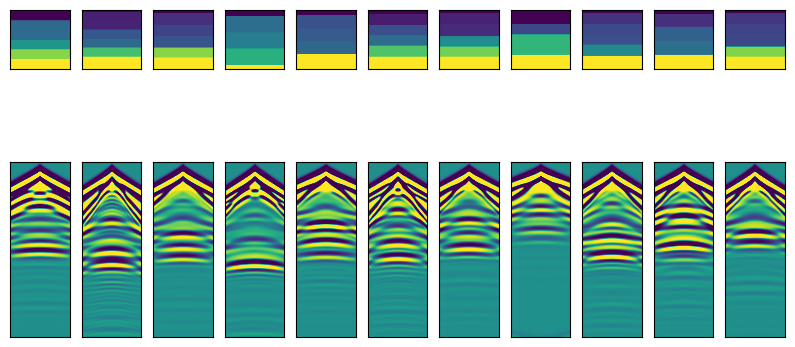

   Epoch: 2    
Epoch [2/100], Batch [0/1500], Loss: 0.0958
Epoch [2/100], Batch [200/1500], Loss: 0.1004
Epoch [2/100], Batch [400/1500], Loss: 0.1013
Epoch [2/100], Batch [600/1500], Loss: 0.1010
Epoch [2/100], Batch [800/1500], Loss: 0.1001
Epoch [2/100], Batch [1000/1500], Loss: 0.0993
Epoch [2/100], Batch [1200/1500], Loss: 0.0987
Epoch [2/100], Batch [1400/1500], Loss: 0.0983
Epoch [2/100], Average Loss: 3.1390
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:07<00:00, 22.30it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:04<00:00, 11196.27it/s]


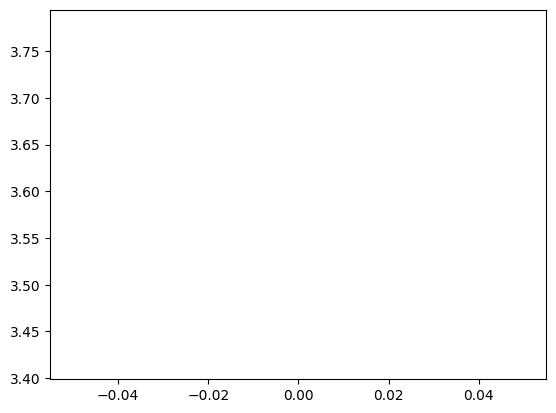

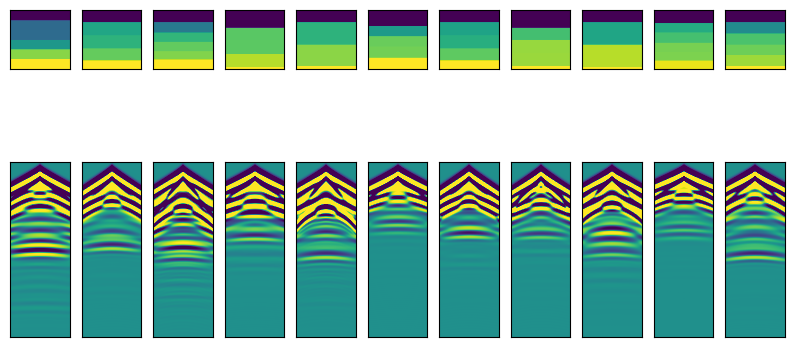

   Epoch: 3    
Epoch [3/100], Batch [0/1500], Loss: 0.0908
Epoch [3/100], Batch [200/1500], Loss: 0.0944
Epoch [3/100], Batch [400/1500], Loss: 0.0942
Epoch [3/100], Batch [600/1500], Loss: 0.0938
Epoch [3/100], Batch [800/1500], Loss: 0.0935
Epoch [3/100], Batch [1000/1500], Loss: 0.0932
Epoch [3/100], Batch [1200/1500], Loss: 0.0929
Epoch [3/100], Batch [1400/1500], Loss: 0.0926
Epoch [3/100], Average Loss: 2.9610
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:39<00:00, 38.35it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 27919.10it/s]


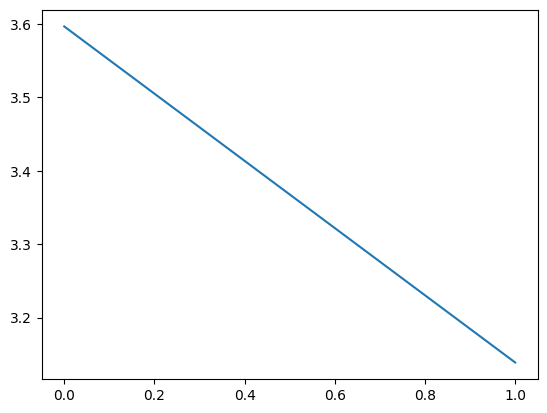

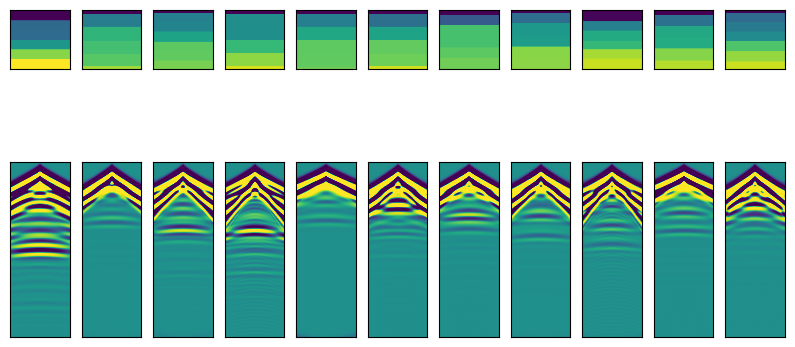

   Epoch: 4    
Epoch [4/100], Batch [0/1500], Loss: 0.0885
Epoch [4/100], Batch [200/1500], Loss: 0.0881
Epoch [4/100], Batch [400/1500], Loss: 0.0896
Epoch [4/100], Batch [600/1500], Loss: 0.0887
Epoch [4/100], Batch [800/1500], Loss: 0.0884
Epoch [4/100], Batch [1000/1500], Loss: 0.0878
Epoch [4/100], Batch [1200/1500], Loss: 0.0881
Epoch [4/100], Batch [1400/1500], Loss: 0.0886
Epoch [4/100], Average Loss: 2.8373
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:10<00:00, 21.40it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 18493.68it/s]


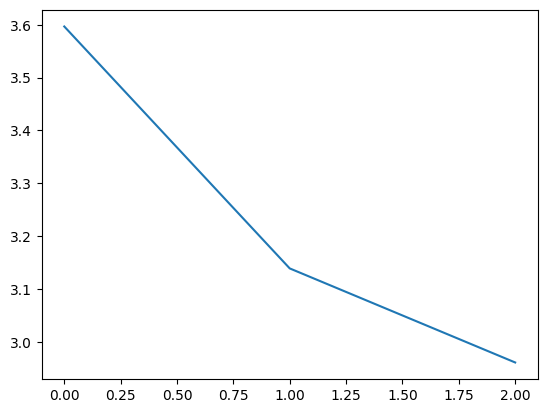

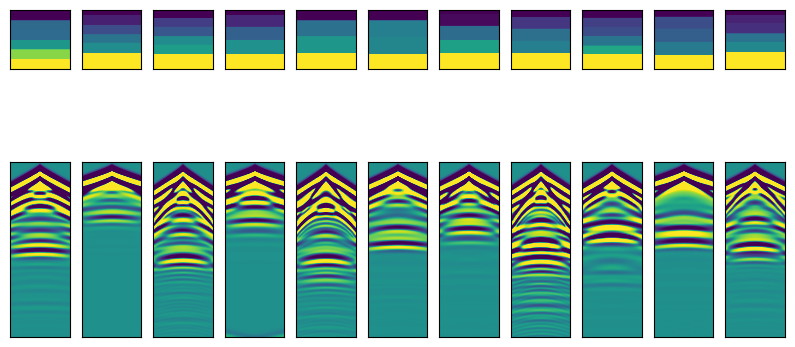

   Epoch: 5    
Epoch [5/100], Batch [0/1500], Loss: 0.0820
Epoch [5/100], Batch [200/1500], Loss: 0.0878
Epoch [5/100], Batch [400/1500], Loss: 0.0862
Epoch [5/100], Batch [600/1500], Loss: 0.0841
Epoch [5/100], Batch [800/1500], Loss: 0.0831
Epoch [5/100], Batch [1000/1500], Loss: 0.0826
Epoch [5/100], Batch [1200/1500], Loss: 0.0819
Epoch [5/100], Batch [1400/1500], Loss: 0.0817
Epoch [5/100], Average Loss: 2.6176
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:10<00:00, 21.23it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:04<00:00, 11599.36it/s]


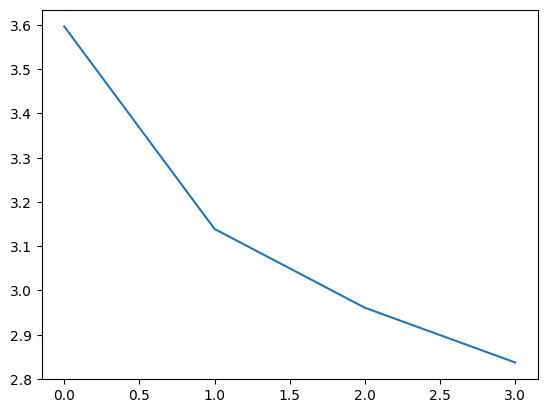

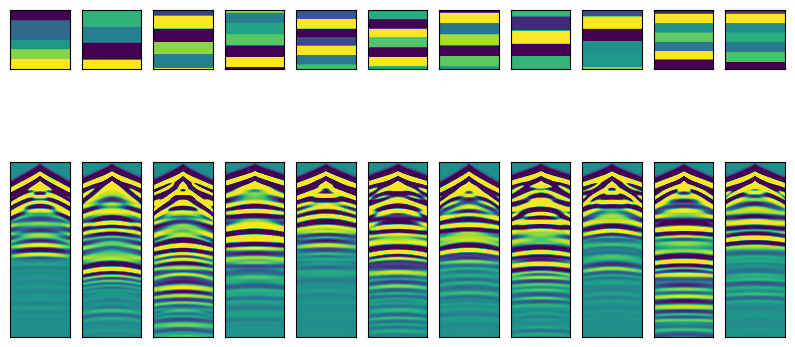

   Epoch: 6    
Epoch [6/100], Batch [0/1500], Loss: 0.1001
Epoch [6/100], Batch [200/1500], Loss: 0.0924
Epoch [6/100], Batch [400/1500], Loss: 0.0867
Epoch [6/100], Batch [600/1500], Loss: 0.0833
Epoch [6/100], Batch [800/1500], Loss: 0.0813
Epoch [6/100], Batch [1000/1500], Loss: 0.0800
Epoch [6/100], Batch [1200/1500], Loss: 0.0787
Epoch [6/100], Batch [1400/1500], Loss: 0.0778
Epoch [6/100], Average Loss: 2.4744
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:09<00:00, 21.45it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13649.24it/s]


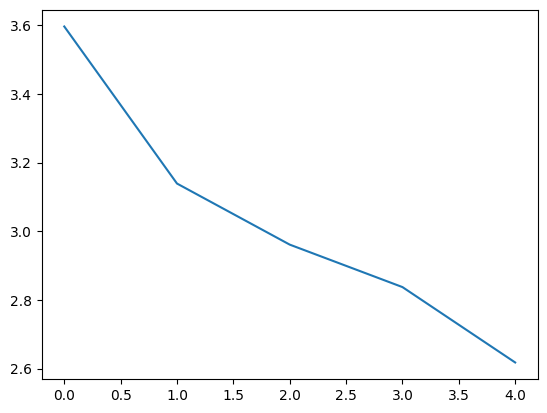

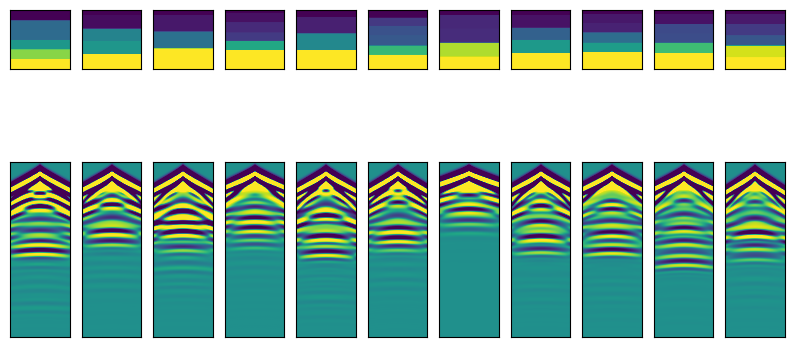

   Epoch: 7    
Epoch [7/100], Batch [0/1500], Loss: 0.0687
Epoch [7/100], Batch [200/1500], Loss: 0.0695
Epoch [7/100], Batch [400/1500], Loss: 0.0719
Epoch [7/100], Batch [600/1500], Loss: 0.0717
Epoch [7/100], Batch [800/1500], Loss: 0.0714
Epoch [7/100], Batch [1000/1500], Loss: 0.0715
Epoch [7/100], Batch [1200/1500], Loss: 0.0711
Epoch [7/100], Batch [1400/1500], Loss: 0.0708
Epoch [7/100], Average Loss: 2.2584
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:06<00:00, 22.52it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13472.44it/s]


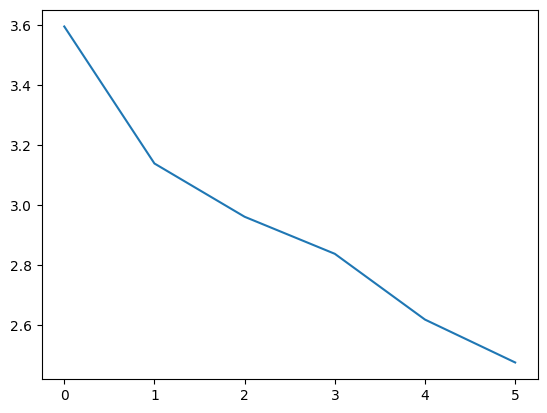

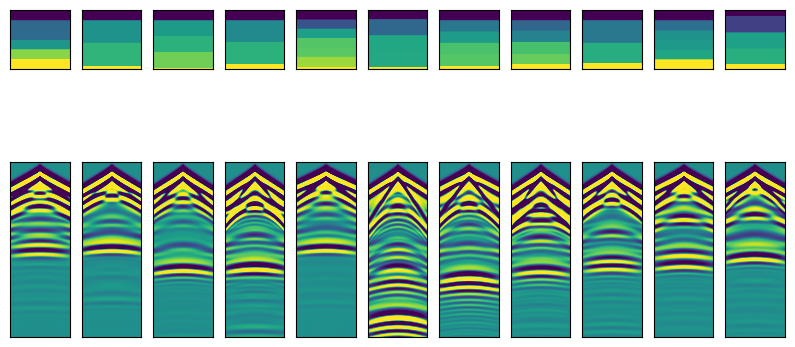

   Epoch: 8    
Epoch [8/100], Batch [0/1500], Loss: 0.0648
Epoch [8/100], Batch [200/1500], Loss: 0.0656
Epoch [8/100], Batch [400/1500], Loss: 0.0649
Epoch [8/100], Batch [600/1500], Loss: 0.0655
Epoch [8/100], Batch [800/1500], Loss: 0.0655
Epoch [8/100], Batch [1000/1500], Loss: 0.0651
Epoch [8/100], Batch [1200/1500], Loss: 0.0655
Epoch [8/100], Batch [1400/1500], Loss: 0.0655
Epoch [8/100], Average Loss: 2.0978
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:48<00:00, 30.88it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████████| 48000/48000 [00:05<00:00, 9468.98it/s]


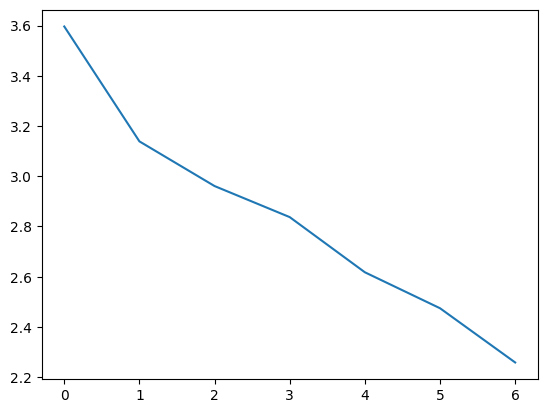

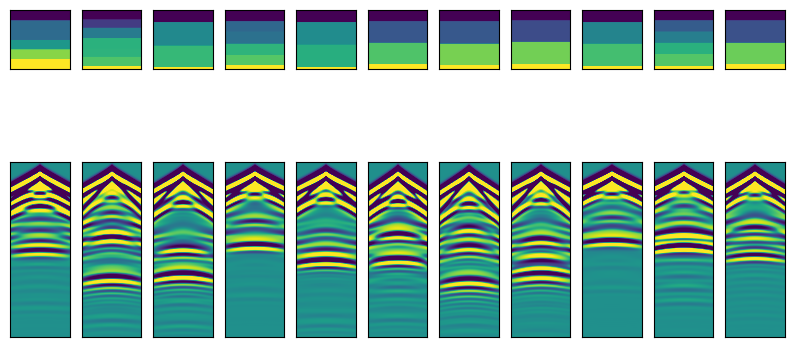

   Epoch: 9    
Epoch [9/100], Batch [0/1500], Loss: 0.0689
Epoch [9/100], Batch [200/1500], Loss: 0.0620
Epoch [9/100], Batch [400/1500], Loss: 0.0621
Epoch [9/100], Batch [600/1500], Loss: 0.0637
Epoch [9/100], Batch [800/1500], Loss: 0.0635
Epoch [9/100], Batch [1000/1500], Loss: 0.0628
Epoch [9/100], Batch [1200/1500], Loss: 0.0623
Epoch [9/100], Batch [1400/1500], Loss: 0.0618
Epoch [9/100], Average Loss: 1.9702
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:04<00:00, 23.37it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 14758.52it/s]


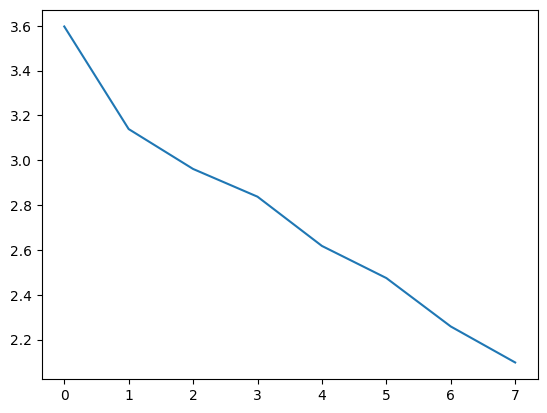

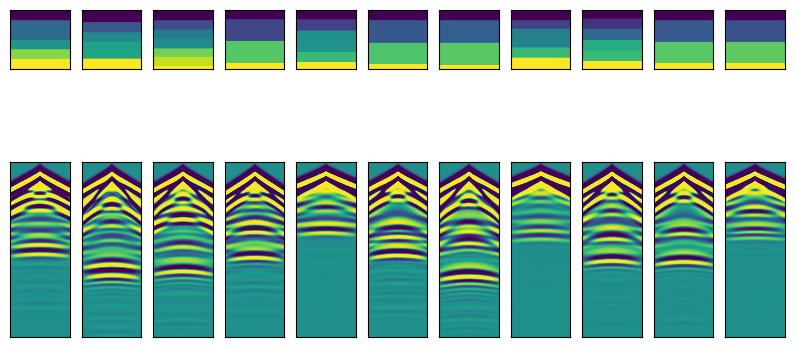

   Epoch: 10    
Epoch [10/100], Batch [0/1500], Loss: 0.0595
Epoch [10/100], Batch [200/1500], Loss: 0.0595
Epoch [10/100], Batch [400/1500], Loss: 0.0588
Epoch [10/100], Batch [600/1500], Loss: 0.0583
Epoch [10/100], Batch [800/1500], Loss: 0.0577
Epoch [10/100], Batch [1000/1500], Loss: 0.0571
Epoch [10/100], Batch [1200/1500], Loss: 0.0567
Epoch [10/100], Batch [1400/1500], Loss: 0.0564
Epoch [10/100], Average Loss: 1.7983
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:00<00:00, 25.00it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 26047.78it/s]


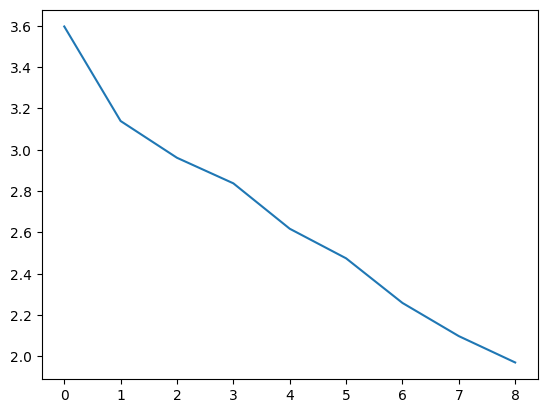

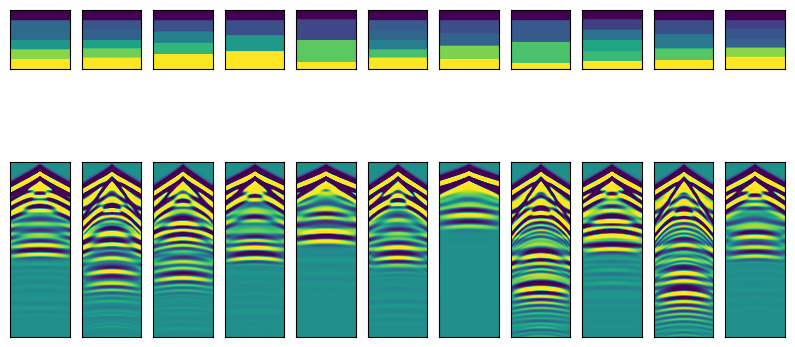

   Epoch: 11    
Epoch [11/100], Batch [0/1500], Loss: 0.0630
Epoch [11/100], Batch [200/1500], Loss: 0.0523
Epoch [11/100], Batch [400/1500], Loss: 0.0524
Epoch [11/100], Batch [600/1500], Loss: 0.0521
Epoch [11/100], Batch [800/1500], Loss: 0.0521
Epoch [11/100], Batch [1000/1500], Loss: 0.0520
Epoch [11/100], Batch [1200/1500], Loss: 0.0520
Epoch [11/100], Batch [1400/1500], Loss: 0.0520
Epoch [11/100], Average Loss: 1.6625
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:09<00:00, 21.48it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12610.08it/s]


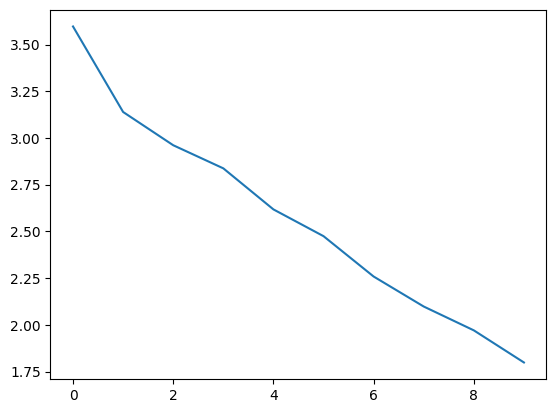

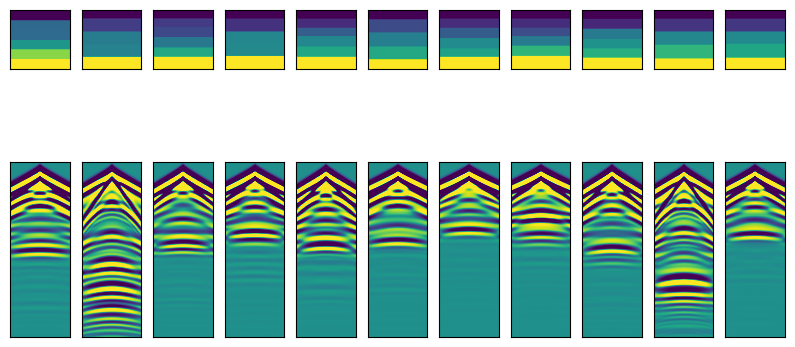

   Epoch: 12    
Epoch [12/100], Batch [0/1500], Loss: 0.0503
Epoch [12/100], Batch [200/1500], Loss: 0.0495
Epoch [12/100], Batch [400/1500], Loss: 0.0499
Epoch [12/100], Batch [600/1500], Loss: 0.0502
Epoch [12/100], Batch [800/1500], Loss: 0.0502
Epoch [12/100], Batch [1000/1500], Loss: 0.0500
Epoch [12/100], Batch [1200/1500], Loss: 0.0498
Epoch [12/100], Batch [1400/1500], Loss: 0.0496
Epoch [12/100], Average Loss: 1.5804
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:08<00:00, 22.01it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:04<00:00, 10675.25it/s]


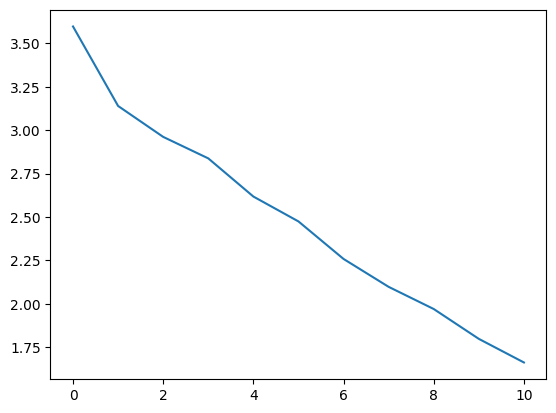

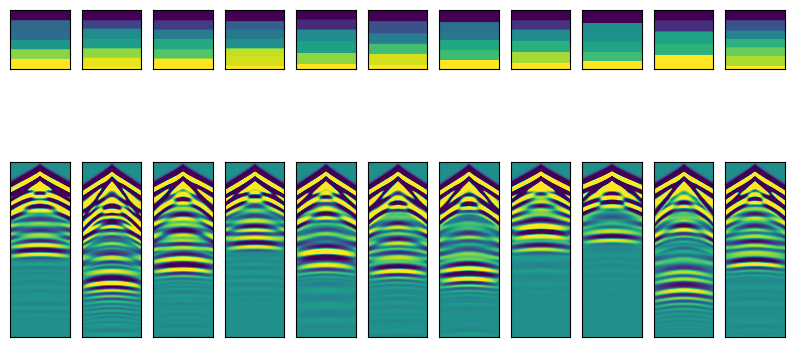

   Epoch: 13    
Epoch [13/100], Batch [0/1500], Loss: 0.0400
Epoch [13/100], Batch [200/1500], Loss: 0.0476
Epoch [13/100], Batch [400/1500], Loss: 0.0472
Epoch [13/100], Batch [600/1500], Loss: 0.0472
Epoch [13/100], Batch [800/1500], Loss: 0.0473
Epoch [13/100], Batch [1000/1500], Loss: 0.0471
Epoch [13/100], Batch [1200/1500], Loss: 0.0468
Epoch [13/100], Batch [1400/1500], Loss: 0.0467
Epoch [13/100], Average Loss: 1.4871
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:10<00:00, 21.21it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 18760.19it/s]


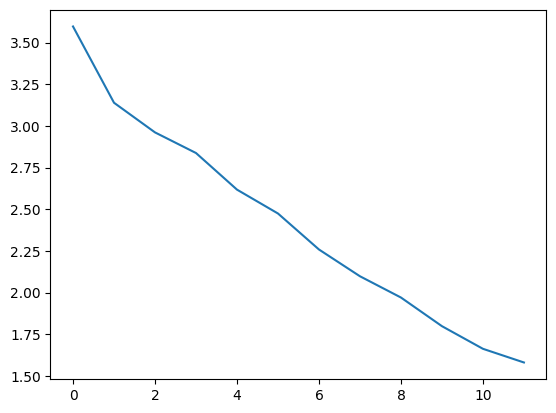

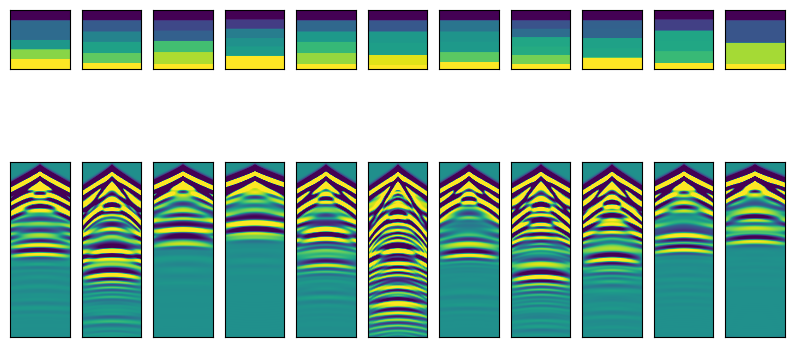

   Epoch: 14    
Epoch [14/100], Batch [0/1500], Loss: 0.0566
Epoch [14/100], Batch [200/1500], Loss: 0.0440
Epoch [14/100], Batch [400/1500], Loss: 0.0430
Epoch [14/100], Batch [600/1500], Loss: 0.0430
Epoch [14/100], Batch [800/1500], Loss: 0.0434
Epoch [14/100], Batch [1000/1500], Loss: 0.0433
Epoch [14/100], Batch [1200/1500], Loss: 0.0433
Epoch [14/100], Batch [1400/1500], Loss: 0.0432
Epoch [14/100], Average Loss: 1.3787
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:11<00:00, 20.96it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 17664.29it/s]


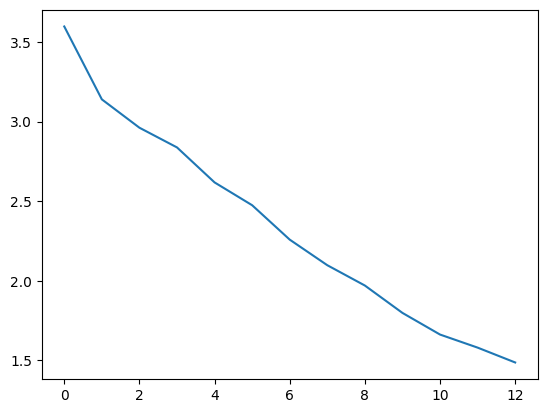

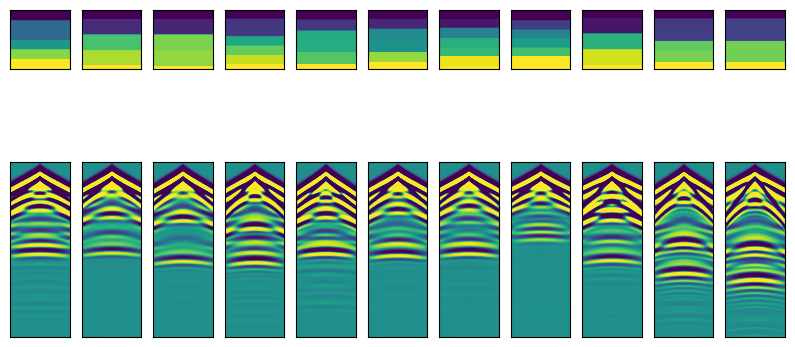

   Epoch: 15    
Epoch [15/100], Batch [0/1500], Loss: 0.0433
Epoch [15/100], Batch [200/1500], Loss: 0.0393
Epoch [15/100], Batch [400/1500], Loss: 0.0396
Epoch [15/100], Batch [600/1500], Loss: 0.0403
Epoch [15/100], Batch [800/1500], Loss: 0.0405
Epoch [15/100], Batch [1000/1500], Loss: 0.0405
Epoch [15/100], Batch [1200/1500], Loss: 0.0406
Epoch [15/100], Batch [1400/1500], Loss: 0.0403
Epoch [15/100], Average Loss: 1.2901
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:39<00:00, 38.17it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 14657.37it/s]


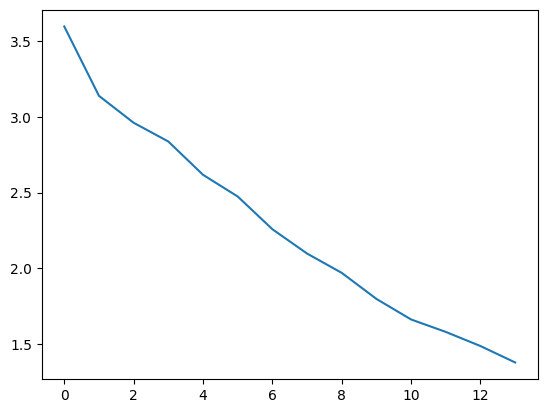

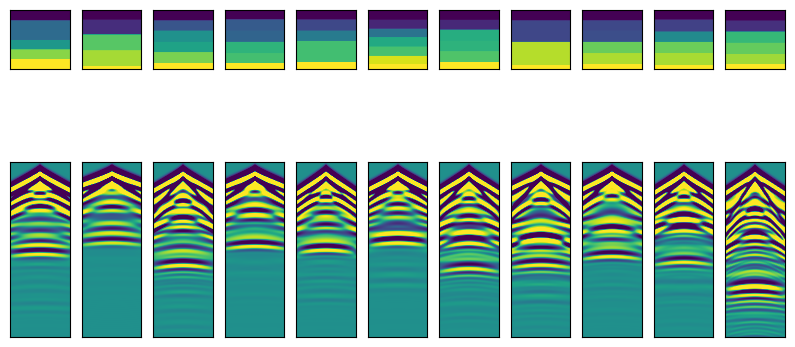

   Epoch: 16    
Epoch [16/100], Batch [0/1500], Loss: 0.0398
Epoch [16/100], Batch [200/1500], Loss: 0.0374
Epoch [16/100], Batch [400/1500], Loss: 0.0383
Epoch [16/100], Batch [600/1500], Loss: 0.0385
Epoch [16/100], Batch [800/1500], Loss: 0.0386
Epoch [16/100], Batch [1000/1500], Loss: 0.0388
Epoch [16/100], Batch [1200/1500], Loss: 0.0388
Epoch [16/100], Batch [1400/1500], Loss: 0.0390
Epoch [16/100], Average Loss: 1.2536
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:13<00:00, 20.27it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13198.83it/s]


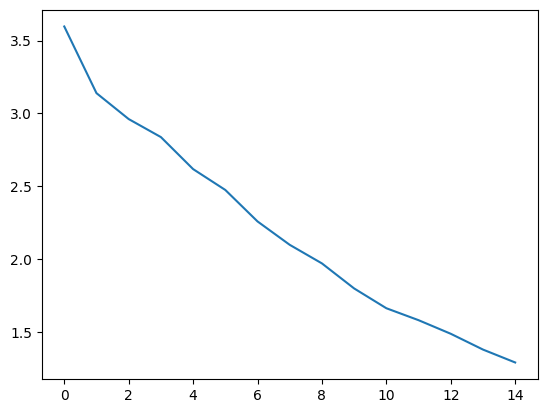

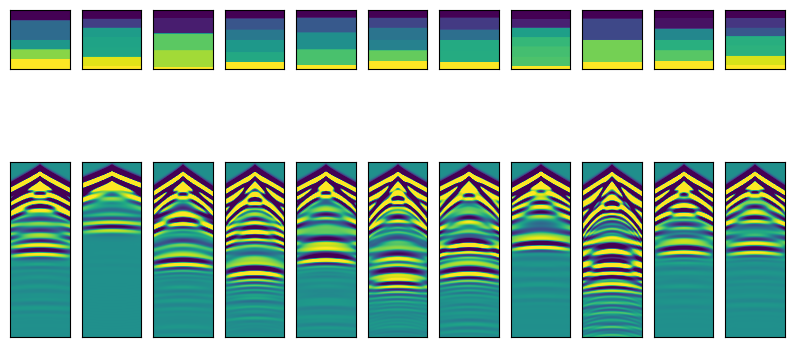

   Epoch: 17    
Epoch [17/100], Batch [0/1500], Loss: 0.0486
Epoch [17/100], Batch [200/1500], Loss: 0.0413
Epoch [17/100], Batch [400/1500], Loss: 0.0410
Epoch [17/100], Batch [600/1500], Loss: 0.0408
Epoch [17/100], Batch [800/1500], Loss: 0.0405
Epoch [17/100], Batch [1000/1500], Loss: 0.0402
Epoch [17/100], Batch [1200/1500], Loss: 0.0398
Epoch [17/100], Batch [1400/1500], Loss: 0.0395
Epoch [17/100], Average Loss: 1.2600
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:55<00:00, 27.09it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 26124.22it/s]


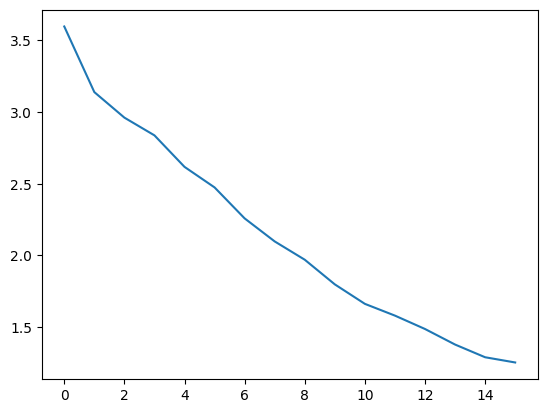

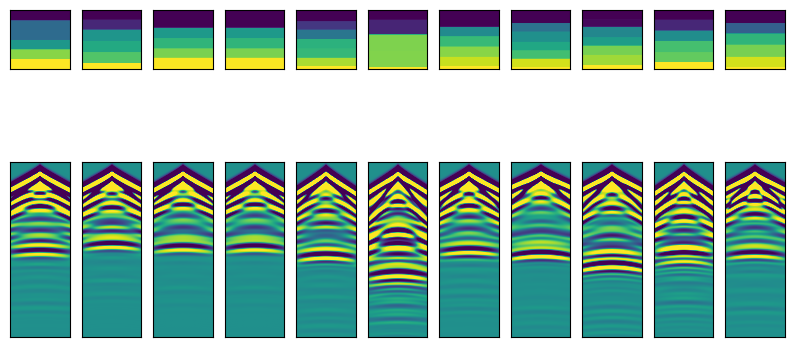

   Epoch: 18    
Epoch [18/100], Batch [0/1500], Loss: 0.0321
Epoch [18/100], Batch [200/1500], Loss: 0.0345
Epoch [18/100], Batch [400/1500], Loss: 0.0350
Epoch [18/100], Batch [600/1500], Loss: 0.0358
Epoch [18/100], Batch [800/1500], Loss: 0.0358
Epoch [18/100], Batch [1000/1500], Loss: 0.0358
Epoch [18/100], Batch [1200/1500], Loss: 0.0363
Epoch [18/100], Batch [1400/1500], Loss: 0.0362
Epoch [18/100], Average Loss: 1.1585
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:14<00:00, 20.02it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12075.31it/s]


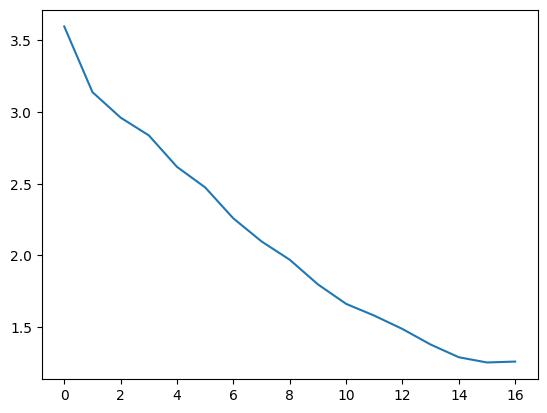

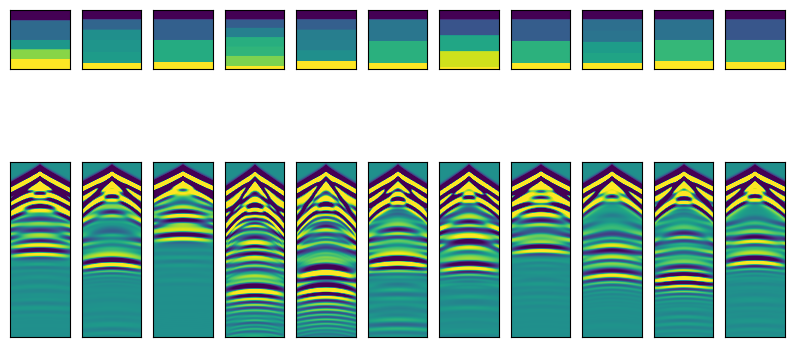

   Epoch: 19    
Epoch [19/100], Batch [0/1500], Loss: 0.0280
Epoch [19/100], Batch [200/1500], Loss: 0.0342
Epoch [19/100], Batch [400/1500], Loss: 0.0339
Epoch [19/100], Batch [600/1500], Loss: 0.0349
Epoch [19/100], Batch [800/1500], Loss: 0.0355
Epoch [19/100], Batch [1000/1500], Loss: 0.0355
Epoch [19/100], Batch [1200/1500], Loss: 0.0356
Epoch [19/100], Batch [1400/1500], Loss: 0.0355
Epoch [19/100], Average Loss: 1.1352
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:11<00:00, 20.97it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 17372.46it/s]


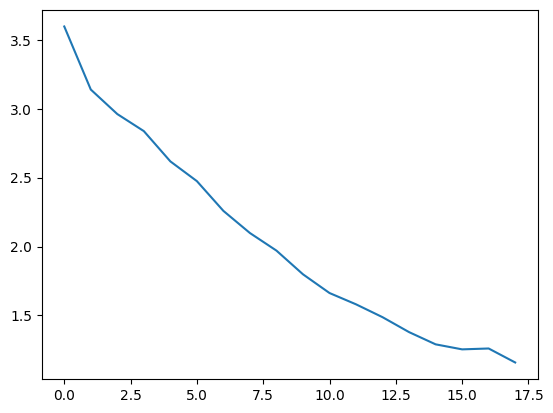

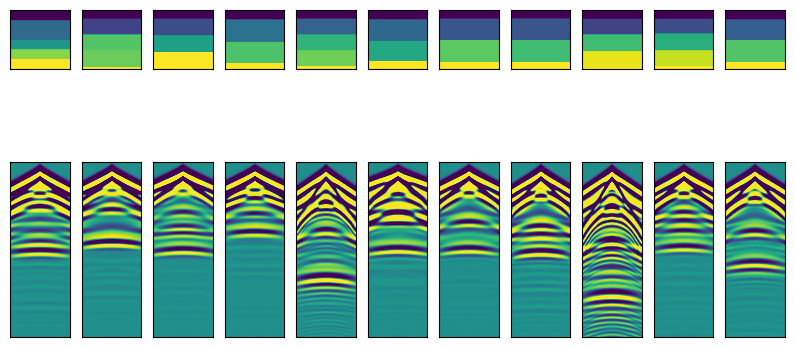

   Epoch: 20    
Epoch [20/100], Batch [0/1500], Loss: 0.0316
Epoch [20/100], Batch [200/1500], Loss: 0.0316
Epoch [20/100], Batch [400/1500], Loss: 0.0329
Epoch [20/100], Batch [600/1500], Loss: 0.0330
Epoch [20/100], Batch [800/1500], Loss: 0.0331
Epoch [20/100], Batch [1000/1500], Loss: 0.0332
Epoch [20/100], Batch [1200/1500], Loss: 0.0332
Epoch [20/100], Batch [1400/1500], Loss: 0.0331
Epoch [20/100], Average Loss: 1.0637
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:09<00:00, 21.56it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13695.97it/s]


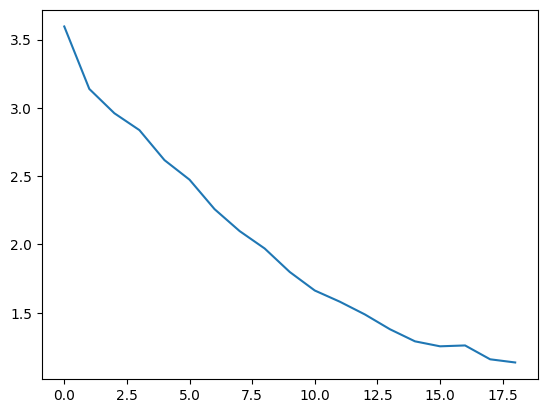

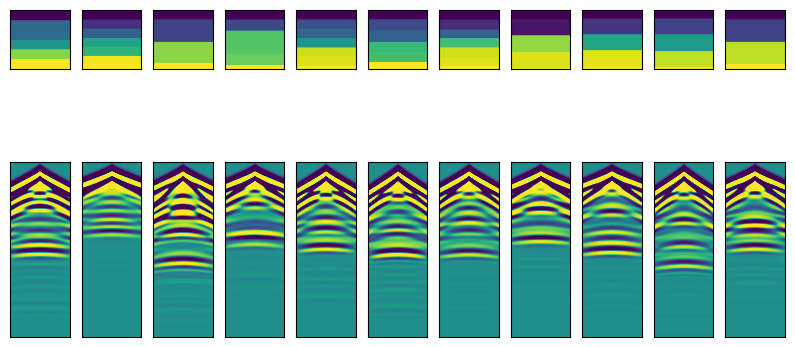

   Epoch: 21    
Epoch [21/100], Batch [0/1500], Loss: 0.0306
Epoch [21/100], Batch [200/1500], Loss: 0.0309
Epoch [21/100], Batch [400/1500], Loss: 0.0307
Epoch [21/100], Batch [600/1500], Loss: 0.0309
Epoch [21/100], Batch [800/1500], Loss: 0.0307
Epoch [21/100], Batch [1000/1500], Loss: 0.0305
Epoch [21/100], Batch [1200/1500], Loss: 0.0305
Epoch [21/100], Batch [1400/1500], Loss: 0.0304
Epoch [21/100], Average Loss: 0.9736
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:09<00:00, 21.51it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13812.86it/s]


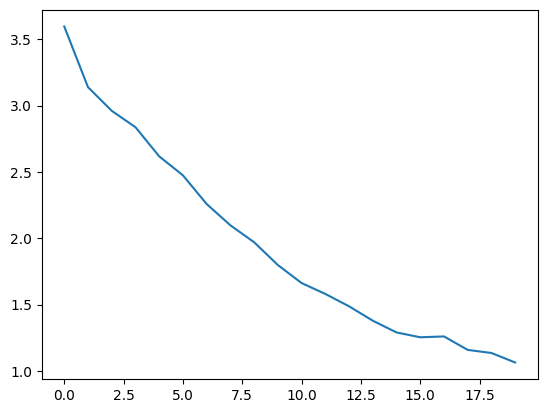

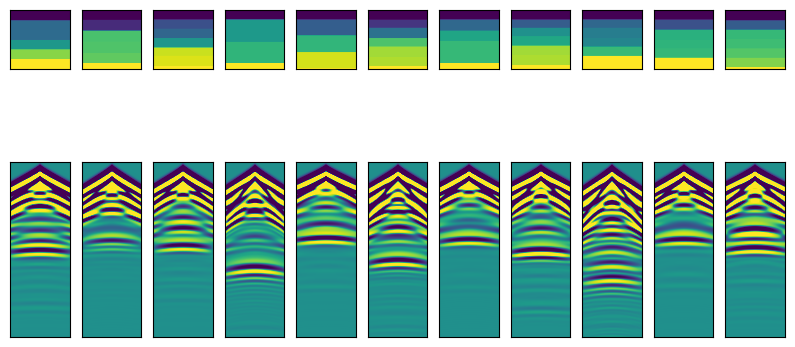

   Epoch: 22    
Epoch [22/100], Batch [0/1500], Loss: 0.0219
Epoch [22/100], Batch [200/1500], Loss: 0.0276
Epoch [22/100], Batch [400/1500], Loss: 0.0273
Epoch [22/100], Batch [600/1500], Loss: 0.0279
Epoch [22/100], Batch [800/1500], Loss: 0.0280
Epoch [22/100], Batch [1000/1500], Loss: 0.0281
Epoch [22/100], Batch [1200/1500], Loss: 0.0282
Epoch [22/100], Batch [1400/1500], Loss: 0.0282
Epoch [22/100], Average Loss: 0.9017
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:42<00:00, 35.69it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 26740.02it/s]


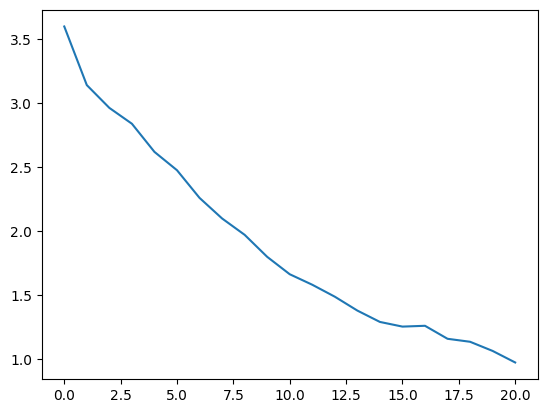

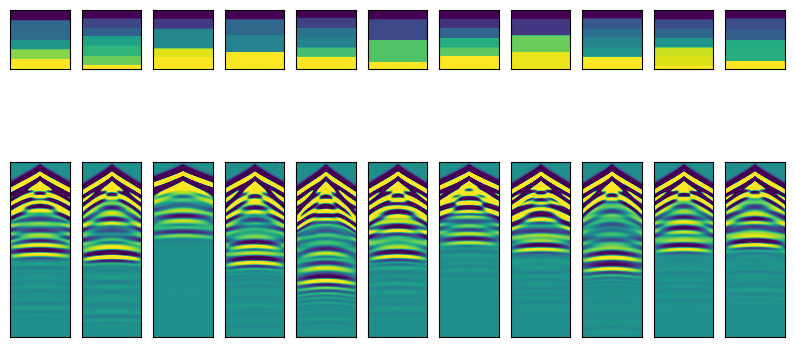

   Epoch: 23    
Epoch [23/100], Batch [0/1500], Loss: 0.0195
Epoch [23/100], Batch [200/1500], Loss: 0.0254
Epoch [23/100], Batch [400/1500], Loss: 0.0258
Epoch [23/100], Batch [600/1500], Loss: 0.0259
Epoch [23/100], Batch [800/1500], Loss: 0.0258
Epoch [23/100], Batch [1000/1500], Loss: 0.0259
Epoch [23/100], Batch [1200/1500], Loss: 0.0259
Epoch [23/100], Batch [1400/1500], Loss: 0.0257
Epoch [23/100], Average Loss: 0.8240
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:06<00:00, 22.61it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12293.46it/s]


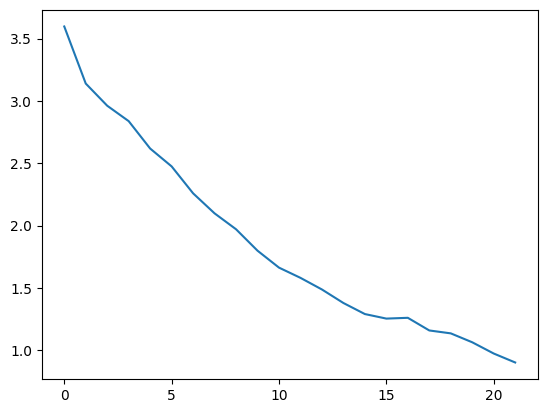

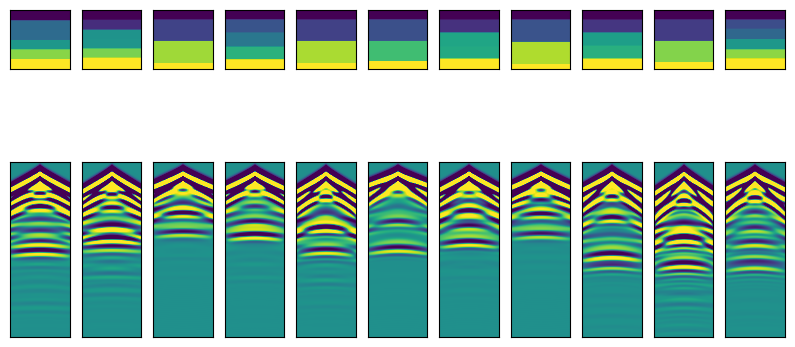

   Epoch: 24    
Epoch [24/100], Batch [0/1500], Loss: 0.0161
Epoch [24/100], Batch [200/1500], Loss: 0.0229
Epoch [24/100], Batch [400/1500], Loss: 0.0236
Epoch [24/100], Batch [600/1500], Loss: 0.0238
Epoch [24/100], Batch [800/1500], Loss: 0.0237
Epoch [24/100], Batch [1000/1500], Loss: 0.0241
Epoch [24/100], Batch [1200/1500], Loss: 0.0240
Epoch [24/100], Batch [1400/1500], Loss: 0.0240
Epoch [24/100], Average Loss: 0.7669
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:01<00:00, 24.55it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12088.99it/s]


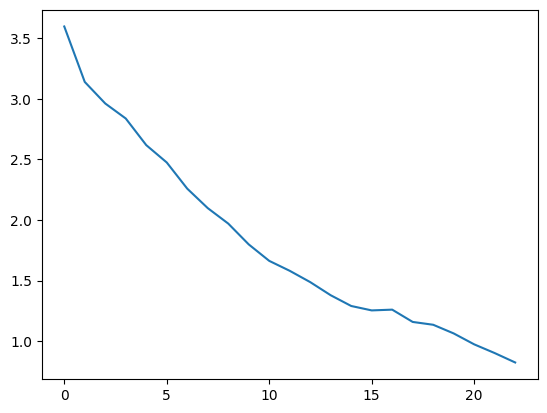

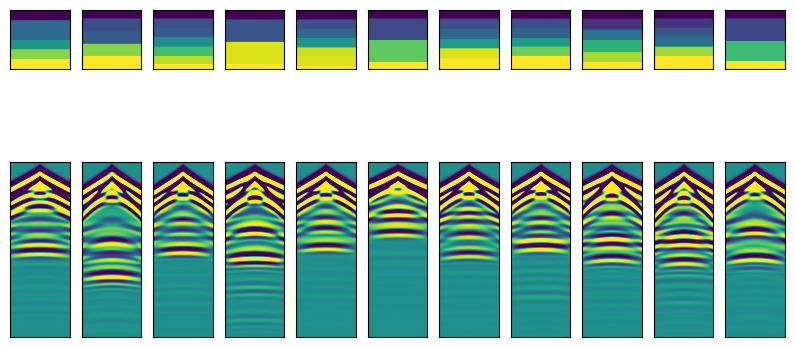

   Epoch: 25    
Epoch [25/100], Batch [0/1500], Loss: 0.0186
Epoch [25/100], Batch [200/1500], Loss: 0.0209
Epoch [25/100], Batch [400/1500], Loss: 0.0217
Epoch [25/100], Batch [600/1500], Loss: 0.0221
Epoch [25/100], Batch [800/1500], Loss: 0.0223
Epoch [25/100], Batch [1000/1500], Loss: 0.0230
Epoch [25/100], Batch [1200/1500], Loss: 0.0230
Epoch [25/100], Batch [1400/1500], Loss: 0.0230
Epoch [25/100], Average Loss: 0.7375
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:14<00:00, 20.22it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12285.00it/s]


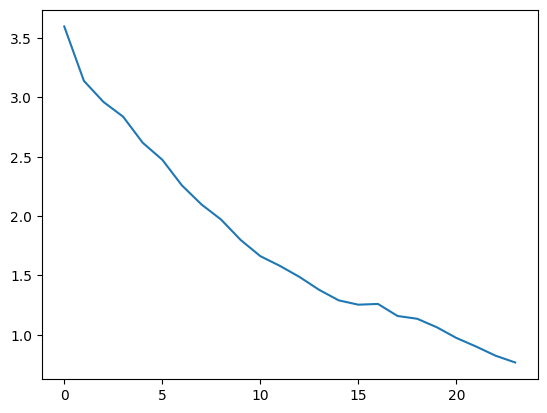

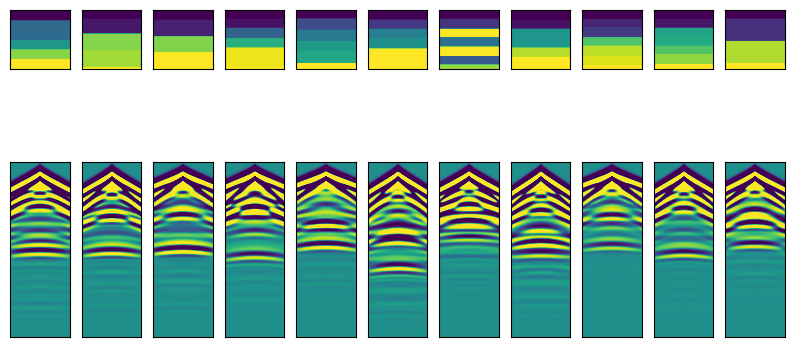

   Epoch: 26    
Epoch [26/100], Batch [0/1500], Loss: 0.0174
Epoch [26/100], Batch [200/1500], Loss: 0.0216
Epoch [26/100], Batch [400/1500], Loss: 0.0217
Epoch [26/100], Batch [600/1500], Loss: 0.0216
Epoch [26/100], Batch [800/1500], Loss: 0.0214
Epoch [26/100], Batch [1000/1500], Loss: 0.0213
Epoch [26/100], Batch [1200/1500], Loss: 0.0216
Epoch [26/100], Batch [1400/1500], Loss: 0.0215
Epoch [26/100], Average Loss: 0.6903
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:59<00:00, 25.24it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13621.96it/s]


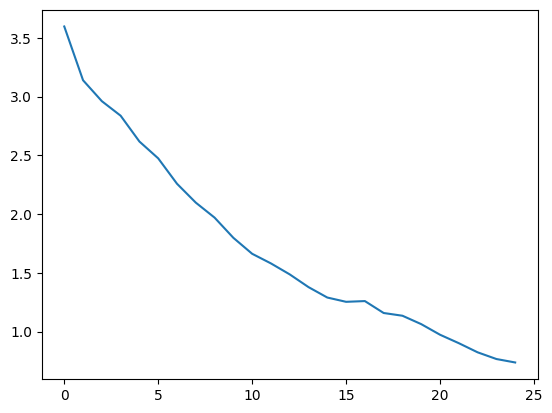

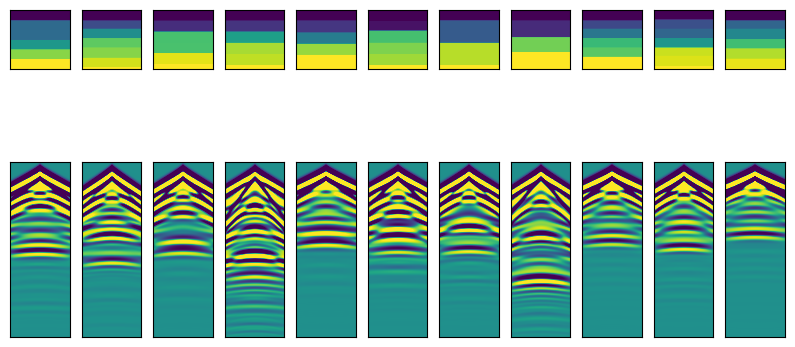

   Epoch: 27    
Epoch [27/100], Batch [0/1500], Loss: 0.0103
Epoch [27/100], Batch [200/1500], Loss: 0.0204
Epoch [27/100], Batch [400/1500], Loss: 0.0221
Epoch [27/100], Batch [600/1500], Loss: 0.0236
Epoch [27/100], Batch [800/1500], Loss: 0.0231
Epoch [27/100], Batch [1000/1500], Loss: 0.0226
Epoch [27/100], Batch [1200/1500], Loss: 0.0224
Epoch [27/100], Batch [1400/1500], Loss: 0.0225
Epoch [27/100], Average Loss: 0.7202
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:37<00:00, 39.60it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 20336.55it/s]


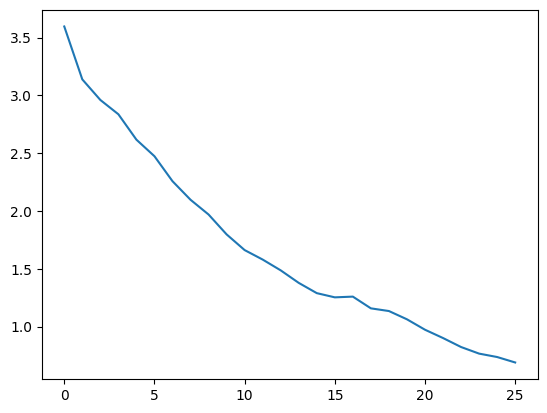

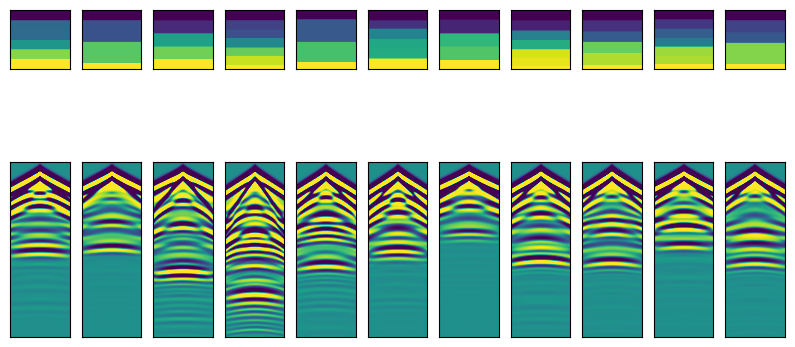

   Epoch: 28    
Epoch [28/100], Batch [0/1500], Loss: 0.0223
Epoch [28/100], Batch [200/1500], Loss: 0.0190
Epoch [28/100], Batch [400/1500], Loss: 0.0192
Epoch [28/100], Batch [600/1500], Loss: 0.0194
Epoch [28/100], Batch [800/1500], Loss: 0.0198
Epoch [28/100], Batch [1000/1500], Loss: 0.0206
Epoch [28/100], Batch [1200/1500], Loss: 0.0211
Epoch [28/100], Batch [1400/1500], Loss: 0.0214
Epoch [28/100], Average Loss: 0.6887
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:02<00:00, 23.88it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:04<00:00, 10810.84it/s]


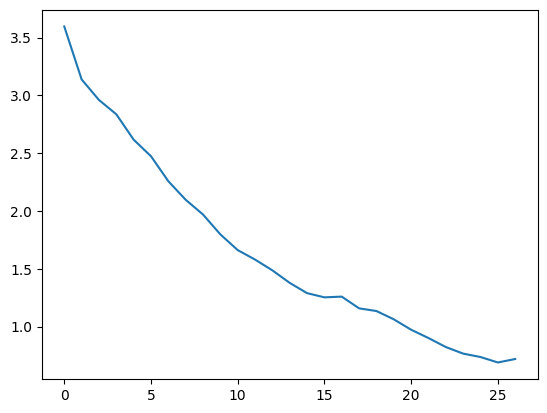

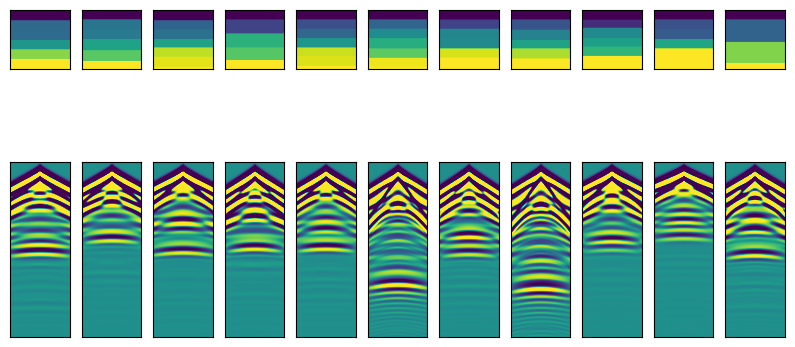

   Epoch: 29    
Epoch [29/100], Batch [0/1500], Loss: 0.0172
Epoch [29/100], Batch [200/1500], Loss: 0.0190
Epoch [29/100], Batch [400/1500], Loss: 0.0190
Epoch [29/100], Batch [600/1500], Loss: 0.0192
Epoch [29/100], Batch [800/1500], Loss: 0.0192
Epoch [29/100], Batch [1000/1500], Loss: 0.0193
Epoch [29/100], Batch [1200/1500], Loss: 0.0193
Epoch [29/100], Batch [1400/1500], Loss: 0.0192
Epoch [29/100], Average Loss: 0.6186
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:56<00:00, 26.51it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 13317.79it/s]


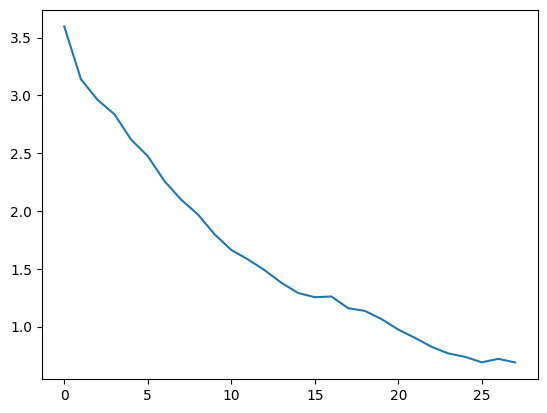

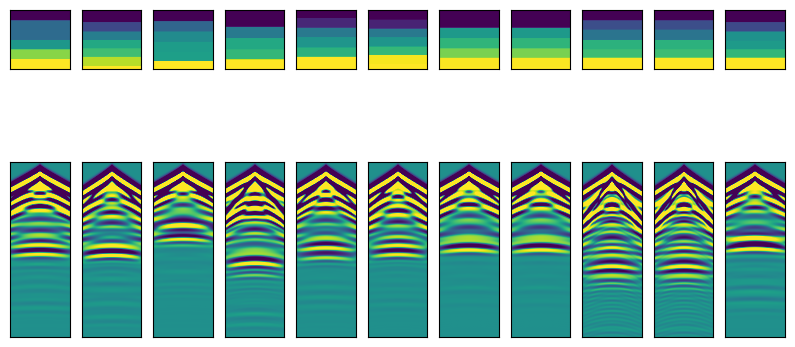

   Epoch: 30    
Epoch [30/100], Batch [0/1500], Loss: 0.0112
Epoch [30/100], Batch [200/1500], Loss: 0.0172
Epoch [30/100], Batch [400/1500], Loss: 0.0176
Epoch [30/100], Batch [600/1500], Loss: 0.0176
Epoch [30/100], Batch [800/1500], Loss: 0.0175
Epoch [30/100], Batch [1000/1500], Loss: 0.0176
Epoch [30/100], Batch [1200/1500], Loss: 0.0175
Epoch [30/100], Batch [1400/1500], Loss: 0.0175
Epoch [30/100], Average Loss: 0.5585
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:03<00:00, 23.80it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12820.61it/s]


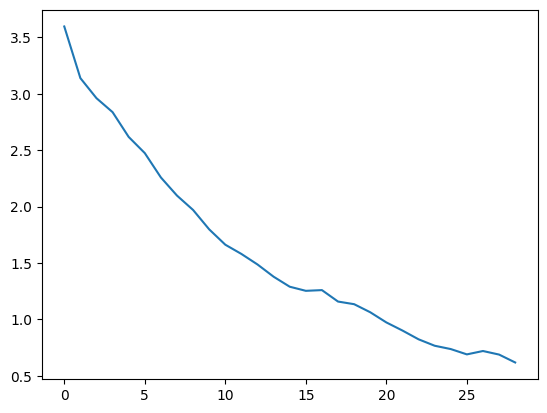

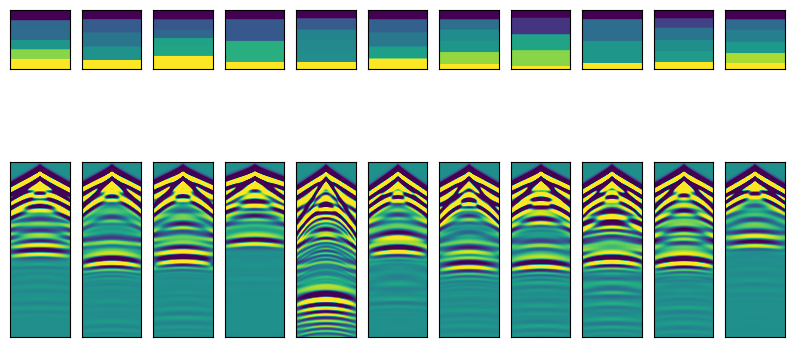

   Epoch: 31    
Epoch [31/100], Batch [0/1500], Loss: 0.0178
Epoch [31/100], Batch [200/1500], Loss: 0.0155
Epoch [31/100], Batch [400/1500], Loss: 0.0154
Epoch [31/100], Batch [600/1500], Loss: 0.0154
Epoch [31/100], Batch [800/1500], Loss: 0.0155
Epoch [31/100], Batch [1000/1500], Loss: 0.0156
Epoch [31/100], Batch [1200/1500], Loss: 0.0157
Epoch [31/100], Batch [1400/1500], Loss: 0.0158
Epoch [31/100], Average Loss: 0.5059
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:11<00:00, 21.06it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 19756.55it/s]


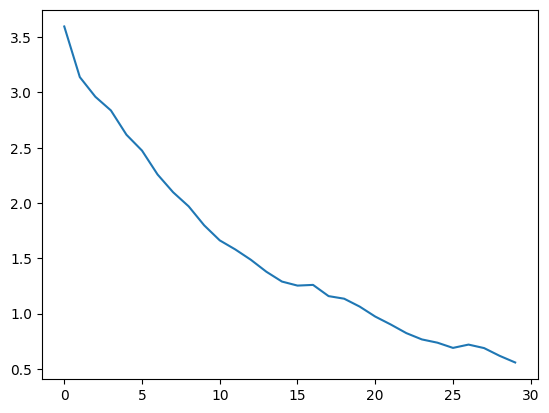

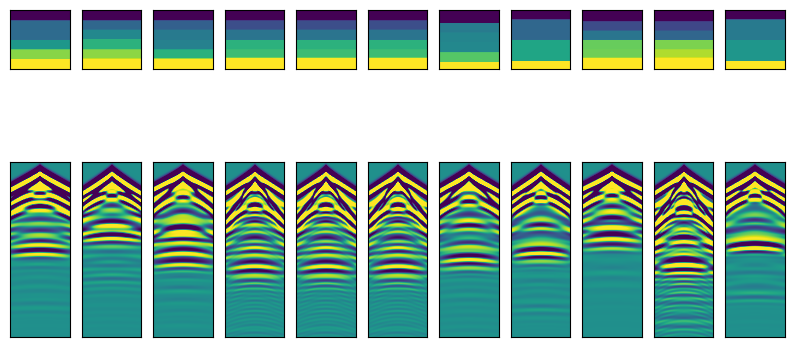

   Epoch: 32    
Epoch [32/100], Batch [0/1500], Loss: 0.0140
Epoch [32/100], Batch [200/1500], Loss: 0.0158
Epoch [32/100], Batch [400/1500], Loss: 0.0154
Epoch [32/100], Batch [600/1500], Loss: 0.0152
Epoch [32/100], Batch [800/1500], Loss: 0.0155
Epoch [32/100], Batch [1000/1500], Loss: 0.0159
Epoch [32/100], Batch [1200/1500], Loss: 0.0160
Epoch [32/100], Batch [1400/1500], Loss: 0.0163
Epoch [32/100], Average Loss: 0.5226
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:40<00:00, 36.66it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:01<00:00, 28143.10it/s]


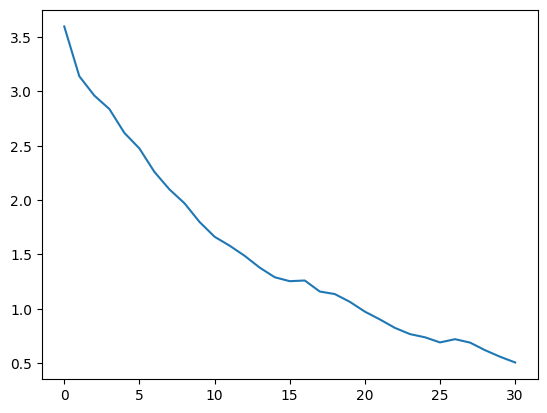

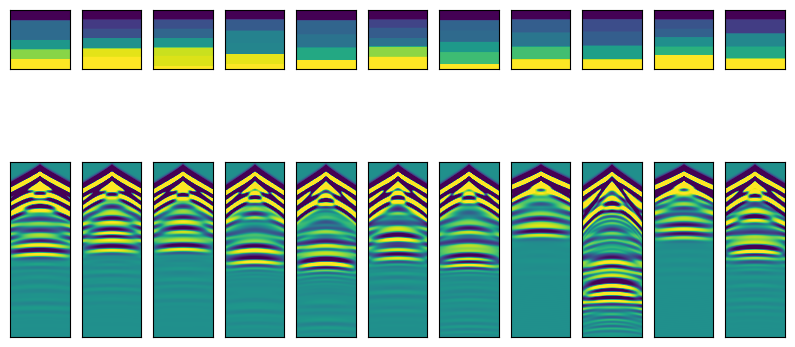

   Epoch: 33    
Epoch [33/100], Batch [0/1500], Loss: 0.0095
Epoch [33/100], Batch [200/1500], Loss: 0.0176
Epoch [33/100], Batch [400/1500], Loss: 0.0171
Epoch [33/100], Batch [600/1500], Loss: 0.0167
Epoch [33/100], Batch [800/1500], Loss: 0.0165
Epoch [33/100], Batch [1000/1500], Loss: 0.0169
Epoch [33/100], Batch [1200/1500], Loss: 0.0170
Epoch [33/100], Batch [1400/1500], Loss: 0.0172
Epoch [33/100], Average Loss: 0.5474
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:08<00:00, 22.06it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 18154.31it/s]


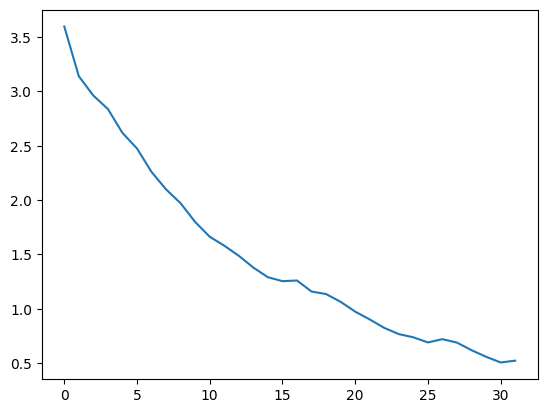

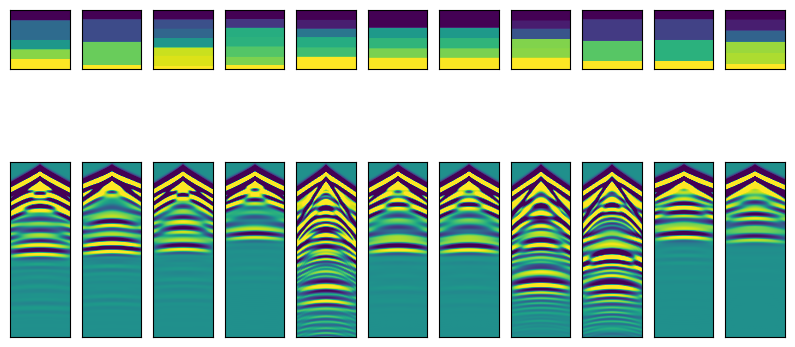

   Epoch: 34    
Epoch [34/100], Batch [0/1500], Loss: 0.0166
Epoch [34/100], Batch [200/1500], Loss: 0.0142
Epoch [34/100], Batch [400/1500], Loss: 0.0141
Epoch [34/100], Batch [600/1500], Loss: 0.0140
Epoch [34/100], Batch [800/1500], Loss: 0.0141
Epoch [34/100], Batch [1000/1500], Loss: 0.0141
Epoch [34/100], Batch [1200/1500], Loss: 0.0141
Epoch [34/100], Batch [1400/1500], Loss: 0.0141
Epoch [34/100], Average Loss: 0.4539
Embedding training set...


100%|█████████████████████████████| 1500/1500 [00:56<00:00, 26.69it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:03<00:00, 12364.58it/s]


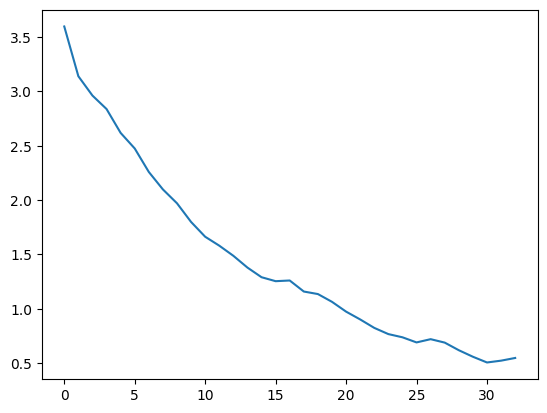

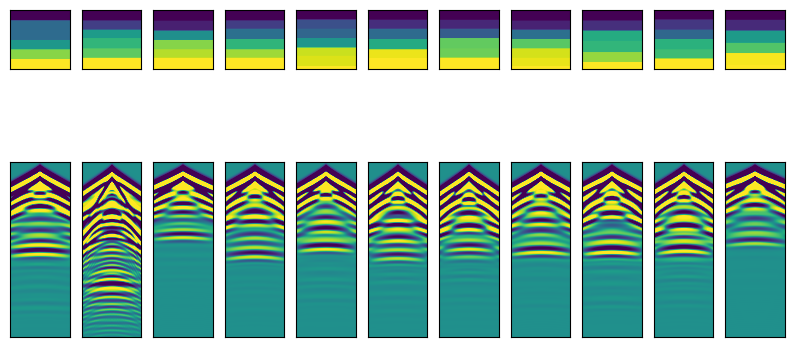

   Epoch: 35    
Epoch [35/100], Batch [0/1500], Loss: 0.0151
Epoch [35/100], Batch [200/1500], Loss: 0.0128
Epoch [35/100], Batch [400/1500], Loss: 0.0129
Epoch [35/100], Batch [600/1500], Loss: 0.0127
Epoch [35/100], Batch [800/1500], Loss: 0.0131
Epoch [35/100], Batch [1000/1500], Loss: 0.0132
Epoch [35/100], Batch [1200/1500], Loss: 0.0131
Epoch [35/100], Batch [1400/1500], Loss: 0.0130
Epoch [35/100], Average Loss: 0.4133
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:05<00:00, 22.98it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:04<00:00, 11498.20it/s]


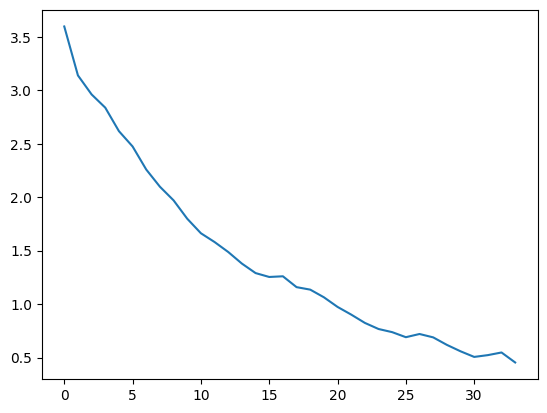

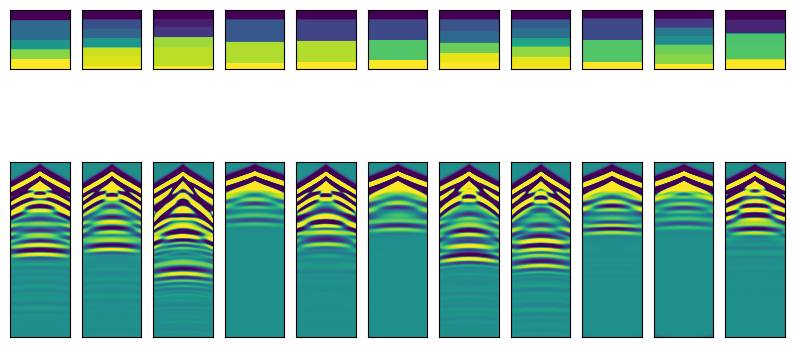

   Epoch: 36    
Epoch [36/100], Batch [0/1500], Loss: 0.0121
Epoch [36/100], Batch [200/1500], Loss: 0.0111
Epoch [36/100], Batch [400/1500], Loss: 0.0114
Epoch [36/100], Batch [600/1500], Loss: 0.0115
Epoch [36/100], Batch [800/1500], Loss: 0.0117
Epoch [36/100], Batch [1000/1500], Loss: 0.0127
Epoch [36/100], Batch [1200/1500], Loss: 0.0131
Epoch [36/100], Batch [1400/1500], Loss: 0.0133
Epoch [36/100], Average Loss: 0.4273
Embedding training set...


100%|█████████████████████████████| 1500/1500 [01:06<00:00, 22.48it/s]


torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|████████████████████████| 48000/48000 [00:02<00:00, 23196.26it/s]


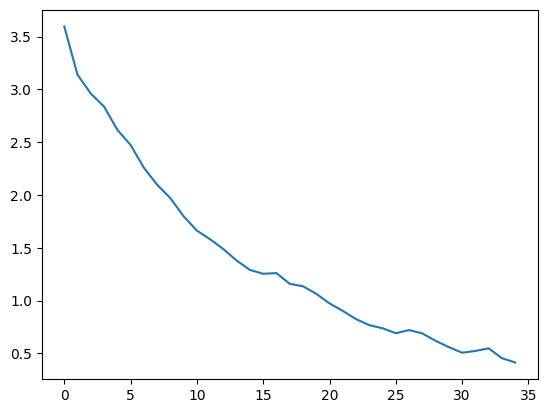

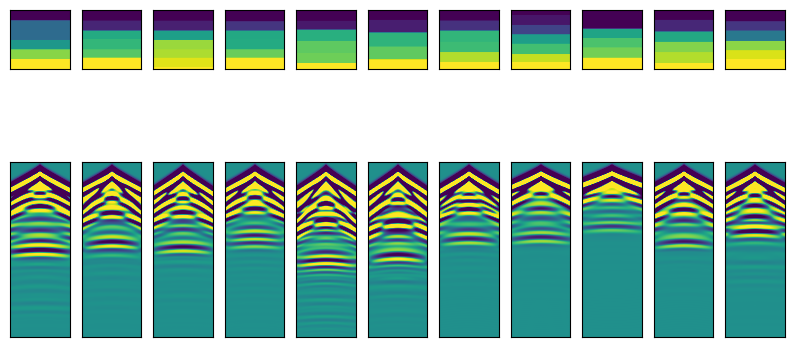

   Epoch: 37    
Epoch [37/100], Batch [0/1500], Loss: 0.0089


In [14]:
if os.path.exists(parent_dir):
    try:
        vit_model_dict, bert_model_dict, image_projector_dict, text_projector_dict, optimizer_state_dict, lr_scheduler_state_dict, losses = \
              load_all(parent_dir)
        print("Loaded checkpoints successfully, continuing training...")
        cont = True
    except Exception as e:
        print(e)
        cont = False
else:
    cont = False

# Hyperparameters
shared_embedding_size = 256  # d_e shared embedding space

# Create model components

# ViT Model
image_size = 64
patch_size = 16
# batch_size = 1
d_model = 256
n_heads = 4
dim_feedforward = 1024
num_layers = 4
image_embedding_size=256  # d_i
num_epochs = 100

vit_model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers)
if cont:
    vit_model.load_state_dict(vit_model_dict)
vit_model.to(device)
print(" Number of Trainable Parameters in", " ViT model :  ",   count_trainable_parameters(vit_model))

# BERT Model
# Configure the BERT model
bert_model = BertForMaskedLM(bert_config)
# saved_bert = torch.load('/home/randycm/Documents/Research/Projects/CLIPS/data/988128checkpoint.pt')
# bert_model.load_state_dict(saved_bert.state_dict())
if cont:
    bert_model.load_state_dict(bert_model_dict)
bert_model.to(device)
max_length = bert_config.max_length
text_embedding_size = bert_config.hidden_size  # d_i

# Load pre-trained DistilBERT model and tokenizer
print(" Number of Trainable Parameters in", " BERT model :  ",  count_trainable_parameters(bert_model))

# Projections  
image_projector = ImageProjection(image_embedding_size, shared_embedding_size)
if cont:
    image_projector.load_state_dict(image_projector_dict)
image_projector.to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size)
if cont:
    text_projector.load_state_dict(text_projector_dict)
text_projector.to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))

# Loss  
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# Optimizer  
params = [
    {"params":vit_model.parameters(), "lr":1e-3 }, {"params":bert_model.parameters(), "lr":1e-4}, 
    {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
]
optimizer = torch.optim.AdamW( params,  weight_decay=0.0 )
if cont:
    optimizer.load_state_dict(optimizer_state_dict)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )
if cont:
    lr_scheduler.load_state_dict(lr_scheduler_state_dict)

# CLIP dataloader
# Initialize dataset with all data
data_dirs = ['/home/randycm/Documents/Research/Transformers/data/E-FWI/FVA/', 
             '/home/randycm/Documents/Research/Transformers/data/E-FWI/FVB/']
shot_indices = [2]

# Create dataset instance without specifying shot_indices to use all shots
dataset = SeismicVelocityDataset2(data_dirs=data_dirs, shot_indices=shot_indices, device='cuda', transform="log1p", alpha=50)

# Get indices for the training-testing split
shuffle = True
total_len = len(dataset)

if shuffle:
    idxs = torch.randperm(total_len)
else:
    idxs = torch.arange(total_len)

train_prop = 0.8
train_len = int(np.ceil(train_prop * total_len))
print("Training data length: ", train_len)
print("Testing data length: ", total_len - train_len)

# Split indices into training and testing
train_idxs = idxs[:train_len]
test_idxs = idxs[train_len:]

# Create subsets for training and testing
clip_trainset = Subset(dataset, train_idxs)
clip_testset = Subset(dataset, test_idxs)

batch_size = 32
clip_trainloader = DataLoader(clip_trainset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4)
    # torch.from_numpy(vels[:90]).repeat_interleave(np.array(seismic_data).shape[1], 0)), batch_size=2, shuffle=True)
clip_testloader = DataLoader(clip_testset, batch_size=batch_size, shuffle=False)
    # torch.from_numpy(vels[90:]).repeat_interleave(np.array(seismic_data).shape[1], 0)), batch_size=2, shuffle=True)
clip_evalloader = DataLoader(clip_trainset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4)

# Prepare samples to monitor training
sample_idx_train = 0
sample_idx_test = 0

sample_train = clip_trainset[sample_idx_train]
sample_test = clip_testset[sample_idx_test]

# Training loop  
if not cont:
    losses = []
start_epoch = len(losses) if cont else 0
for epoch in range(start_epoch, num_epochs):
    print( "   Epoch:", epoch+1, "   "  )
    vit_model.train()
    bert_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (seismic, velocity) in enumerate(clip_trainloader):
        # Forward pass  
        optimizer.zero_grad()
        
        seismic = seismic.to(device)
        velocity = velocity.to(device)
        # Text  
        outputs = bert_model(inputs_embeds=seismic.view(-1,bert_config.max_length,bert_config.vocab_size))
        text_embeddings = outputs.hidden_states[-1].mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # Image  
        image_embeddings = vit_model(velocity)
        image_projection = image_projector(image_embeddings)
        
        #  Compute Loss 
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        #  Backpropagation 
        loss.backward()
        optimizer.step()
        
# if epoch < warmup_epochs:
#   scheduler.step(epoch)
# else:
#   scheduler.step()
        
        # Loss print
        total_loss += loss.item()
        
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(clip_trainloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
    
    # Loss each epoch
    avg_loss = total_loss / len(clip_trainloader)
    lr_scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    losses.append(avg_loss)

    # Validate
    if epoch % 1 == 0: # Every 1 epochs
        vit_model.eval()
        bert_model.eval()
        image_projector.eval()
        text_projector.eval()

        print("Embedding training set...")
        image_embeddings_list_train = []
        with torch.no_grad():
            for batch in tqdm(clip_evalloader):
                images = batch[1].to(device)
                # Create image embeddings for the batch
                image_projections = create_image_embeddings(images, vit_model, image_projector)
                # Add embeddings to the list
                image_embeddings_list_train.extend(image_projections)

        # print("Embedding testing set...")
        # image_embeddings_list_test = []

        # for index in tqdm(range(len(clip_testset))):
        #     images = clip_testset[index][1]
        #     images = images.to(device)
        #     image_projection = create_image_embeddings(images.unsqueeze(0), vit_model, image_projector)
        #     image_embeddings_list_test.append(image_projection[0])

        # Training data
        image_retrieval_function(
        sample_train, 10, bert_config, bert_model, 
        text_projector, image_embeddings_list_train, 
        clip_trainset, display=True, parent_dir=parent_dir, epoch=epoch)

        # # Testing data
        # image_retrieval_function(
        # sample_test, 10, bert_data, bert_model, 
        # text_projector, image_embeddings_list_test, 
        # clip_testset, display=True)
        
        plt.plot(np.array(losses))
        plt.savefig(os.path.join(parent_dir, 'loss.pdf'))

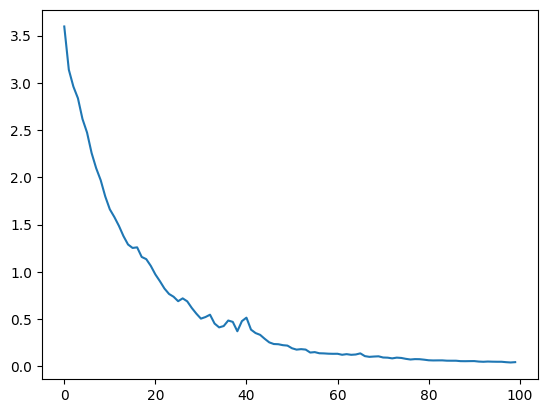

In [15]:
losses = np.array(losses)
plt.plot(losses)

23581
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:03<00:00, 14290.73it/s]


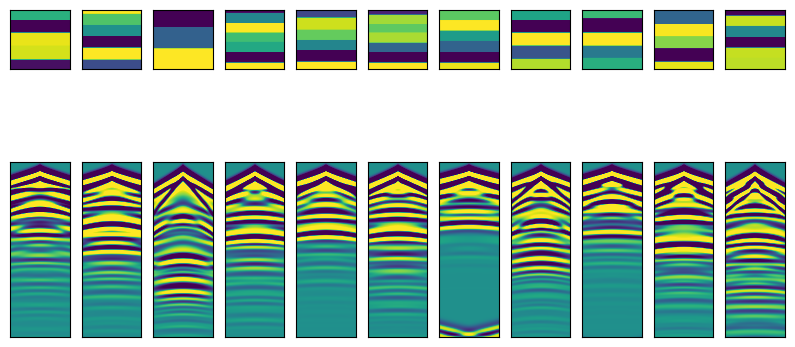

11943
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:02<00:00, 18849.80it/s]


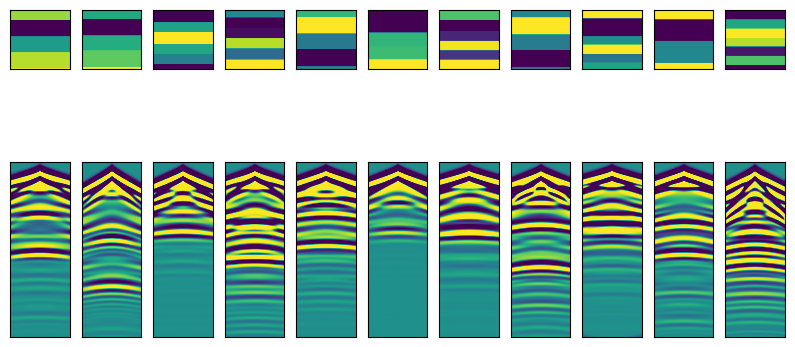

11128
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:01<00:00, 27652.97it/s]


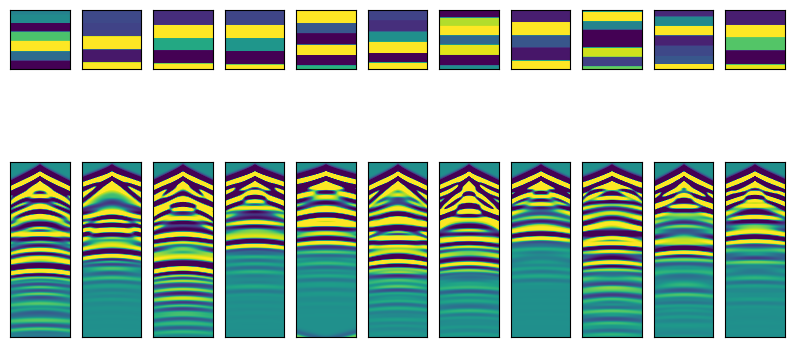

23679
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:02<00:00, 20550.88it/s]


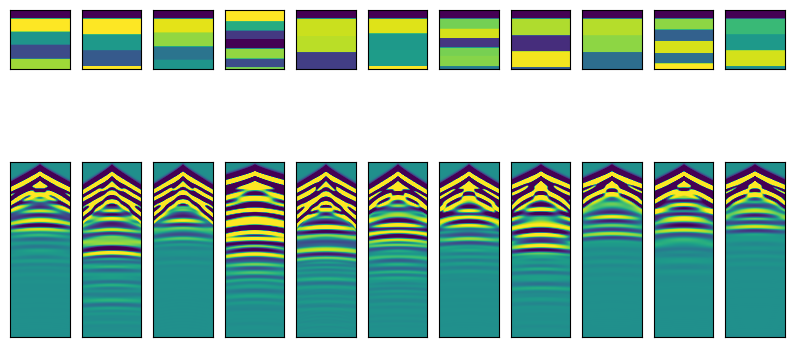

18385
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:01<00:00, 25753.30it/s]


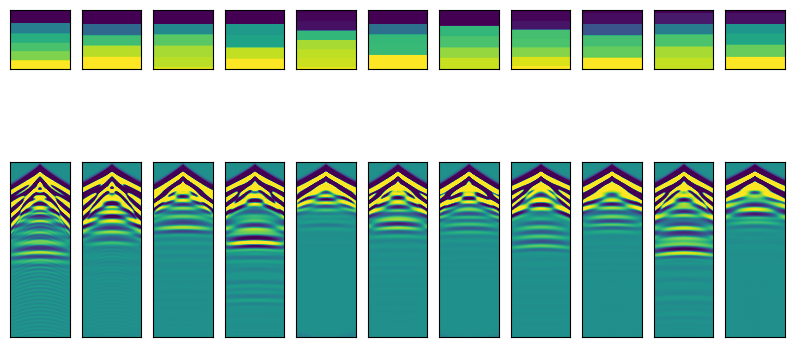

26792
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:03<00:00, 13701.27it/s]


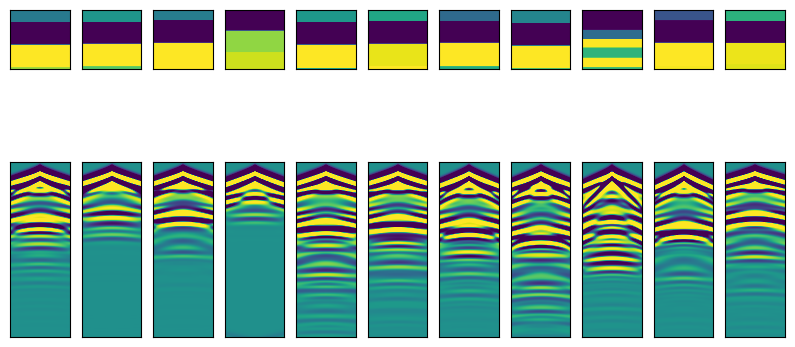

22407
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:04<00:00, 11592.53it/s]


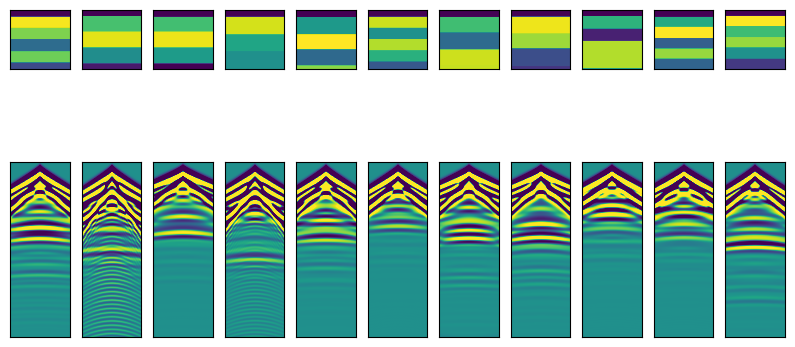

18555
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:04<00:00, 10544.47it/s]


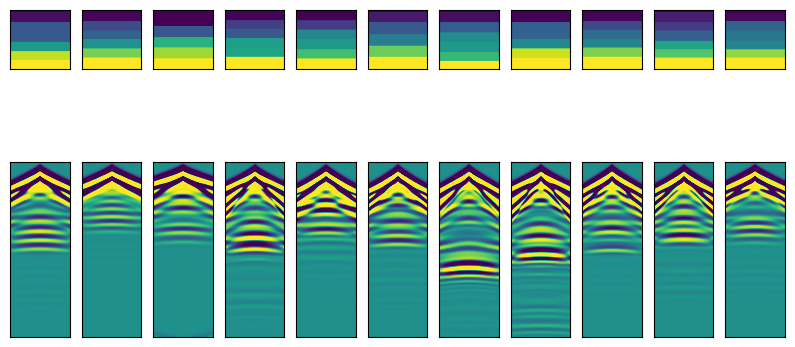

8858
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:03<00:00, 13276.73it/s]


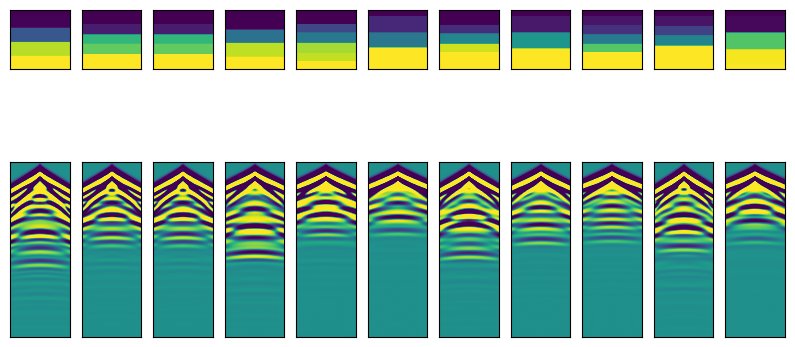

43140
torch.Size([70, 1000]) torch.Size([3, 64, 64])


100%|█████████████████████| 48000/48000 [00:02<00:00, 18842.68it/s]


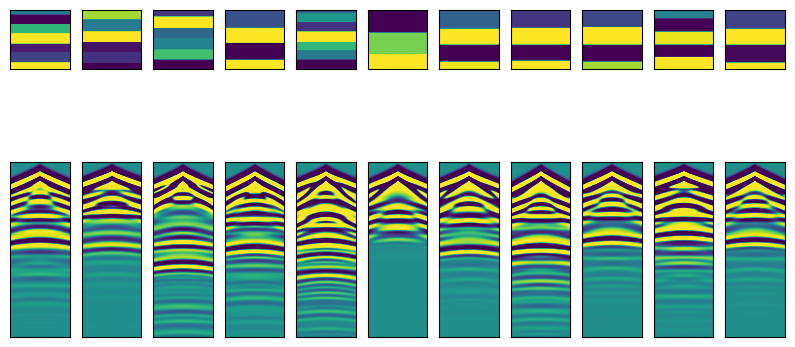

In [16]:
for i in range(10):
    idx = torch.randint(train_len, size=(1,)).item()
    print(idx)
    sample_idx_train = idx

    sample_train = clip_trainset[sample_idx_train]

    image_retrieval_function(
            sample_train, 10, bert_config, bert_model, 
            text_projector, image_embeddings_list_train, 
            clip_trainset, display=True)

In [17]:
def save_all(parent_dir, vit_model, bert_model, image_projector, text_projector, optimizer, lr_scheduler, losses):
    torch.save(vit_model.cpu().state_dict(), os.path.join(parent_dir, 'vit_model.pt'))
    torch.save(bert_model.cpu().state_dict(), os.path.join(parent_dir, 'bert_model.pt'))
    torch.save(image_projector.cpu().state_dict(), os.path.join(parent_dir, 'image_projector.pt'))
    torch.save(text_projector.cpu().state_dict(), os.path.join(parent_dir, 'text_projector.pt'))
    torch.save(optimizer.state_dict(), os.path.join(parent_dir, 'optimizer.pt'))
    torch.save(lr_scheduler.state_dict(), os.path.join(parent_dir, 'lr_scheduler.pt'))
    np.save(os.path.join(parent_dir, 'losses.npy'), losses)

In [18]:
if not os.path.exists(os.path.join(parent_dir, 'vit_model.pt')):
    os.makedirs(parent_dir, exist_ok=True)
    check = 'y'
else:
    check = str(input("Path exists, overwrite? (y/n)"))
if check == 'y':
    save_all(parent_dir, vit_model, bert_model, image_projector, text_projector, optimizer, lr_scheduler, losses)
    print("Saved successfully.")
else:
    print("Saving failed.")

Saved successfully.


# CLIP Testing

In [20]:
def create_image_embeddings(images, vit_model, image_projector):
    with torch.no_grad():
        image_embeddings = vit_model(images)
        image_projection = image_projector(image_embeddings)
    return image_projection

def image_retrieval_function(inputs, n , bert_data, bert_model, text_projector, image_embeddings_list_train, clip_trainset, display=False):
    with torch.no_grad():
        
        print(inputs[0].shape, inputs[1].shape)
        
        plt.figure()
        plt.imshow(inputs[1][0,0].detach().cpu().numpy())
        plt.show()
        
        plt.figure()
        plt.imshow(inputs[0].view(-1,bert_data.shape[-2],bert_data.shape[-1])[0].T.detach().cpu().numpy(),aspect='auto')
        plt.show()
        
        outputs = bert_model(inputs_embeds=inputs[0].view(-1,bert_data.shape[-2],bert_data.shape[-1]))
        text_embeddings = outputs.hidden_states[-1].mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = clip_trainset[index][1]
            plt.imshow(image_tensor[0].detach().cpu().numpy())
            plt.savefig('similar_img_'+str(index)+'.pdf')
            plt.show()
        return None
    else:
        return max_indexes, similarity_scores_list

In [47]:
vit_model.eval()
bert_model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=200, out_features=512, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-15): 16 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (alibi): LinearBiases()
              (urpe): URPE()
            )
        

In [48]:
clip_trainset = SeismicVelocityDataset(
    bert_data[:90], 
    torch.from_numpy(vels[:90])
)

clip_testset = SeismicVelocityDataset(
    bert_data[90:], 
    torch.from_numpy(vels[90:])
)

image_embeddings_list_train = []

for index in tqdm(range(len(clip_trainset))):
    images = clip_trainset[index][1]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0), vit_model, image_projector)
    image_embeddings_list_train.append(image_projection[0])

100%|██████████████████████████████████████████████| 90/90 [00:02<00:00, 40.49it/s]


In [158]:
# Convert the DataLoader to an iterator
data_iter = iter(clip_trainloader)

index_to_access = 20 # Specify the index you want to access

for i in range(index_to_access + 1):
    sample = next(data_iter)

In [135]:
vel_all = torch.from_numpy(vels[90:])

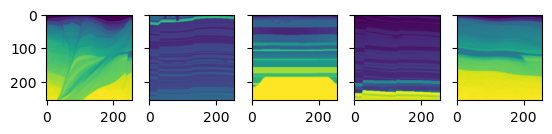

In [155]:
idx = torch.randint(high=len(vel_all), size=(5,))
f, ax = plt.subplots(1, 5, sharey=True)

for i in range(5):
    ax[i].imshow(vel_all[idx[i], 0])

torch.Size([2, 64, 200]) torch.Size([2, 3, 256, 256])


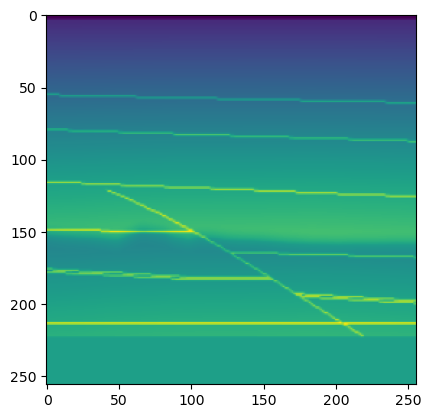

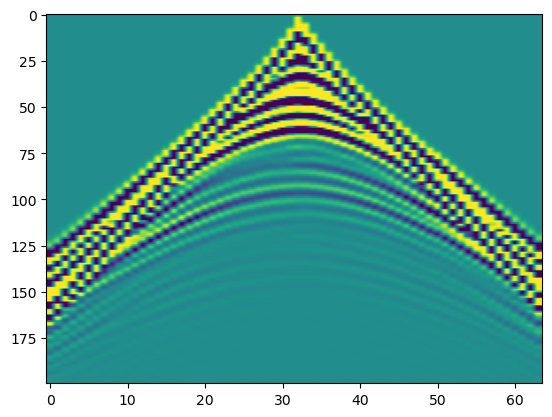

100%|███████████████████████████████████████████| 90/90 [00:00<00:00, 22689.63it/s]


In [159]:
# Inference
max_index, score = image_retrieval_function(
    sample, 10, bert_data, bert_model, 
    text_projector, image_embeddings_list_train, 
    clip_trainset, display=False
)

In [160]:
max_index

array([85, 61, 12, 77,  9, 73, 23, 70, 82, 45])

In [161]:
score

[array(106.34853, dtype=float32),
 array(106.3492, dtype=float32),
 array(106.34884, dtype=float32),
 array(106.34903, dtype=float32),
 array(106.34899, dtype=float32),
 array(106.34879, dtype=float32),
 array(106.34869, dtype=float32),
 array(106.34894, dtype=float32),
 array(106.34851, dtype=float32),
 array(106.349556, dtype=float32),
 array(106.34828, dtype=float32),
 array(106.34867, dtype=float32),
 array(106.34971, dtype=float32),
 array(106.34894, dtype=float32),
 array(106.34851, dtype=float32),
 array(106.348434, dtype=float32),
 array(106.348694, dtype=float32),
 array(106.34856, dtype=float32),
 array(106.34827, dtype=float32),
 array(106.34883, dtype=float32),
 array(106.34862, dtype=float32),
 array(106.34816, dtype=float32),
 array(106.348724, dtype=float32),
 array(106.34951, dtype=float32),
 array(106.34877, dtype=float32),
 array(106.34828, dtype=float32),
 array(106.34916, dtype=float32),
 array(106.34761, dtype=float32),
 array(106.348724, dtype=float32),
 array(106

torch.Size([2, 64, 200]) torch.Size([2, 3, 256, 256])


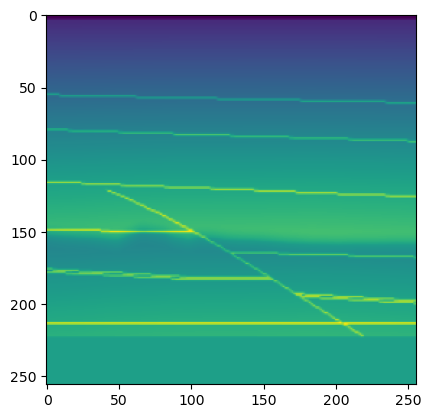

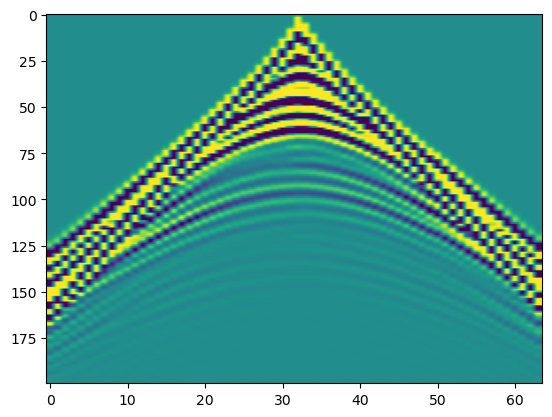

100%|███████████████████████████████████████████| 90/90 [00:00<00:00, 10281.84it/s]


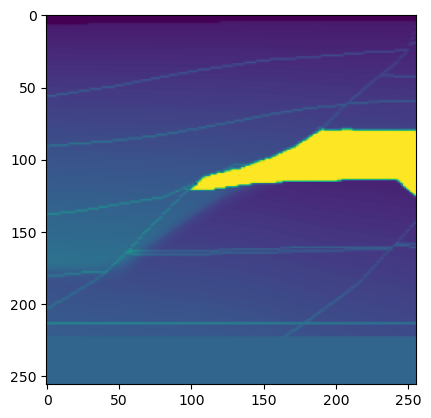

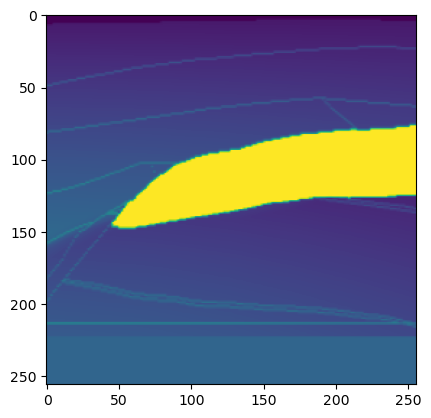

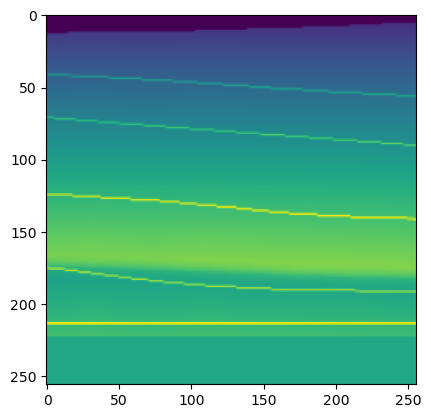

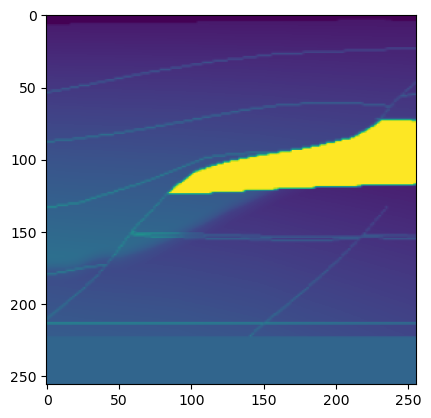

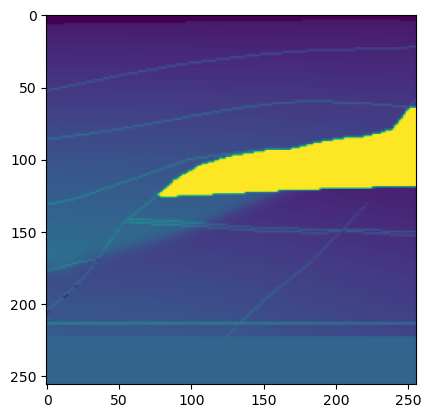

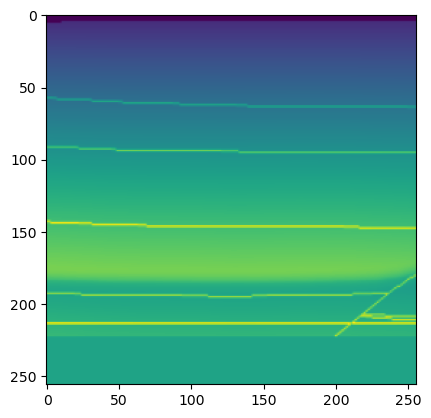

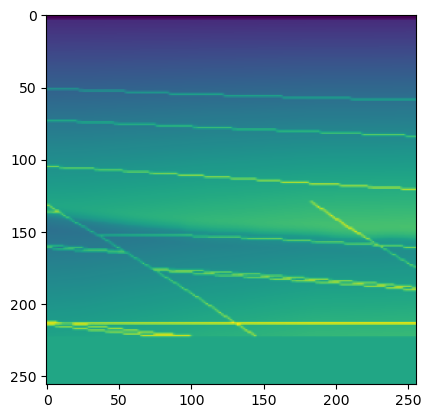

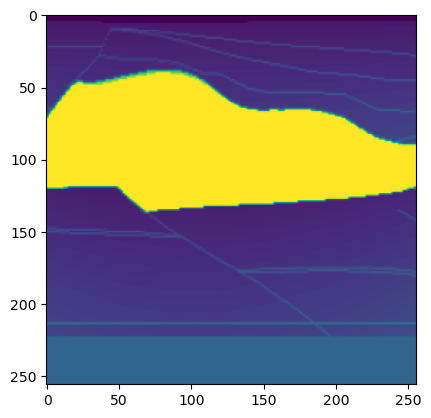

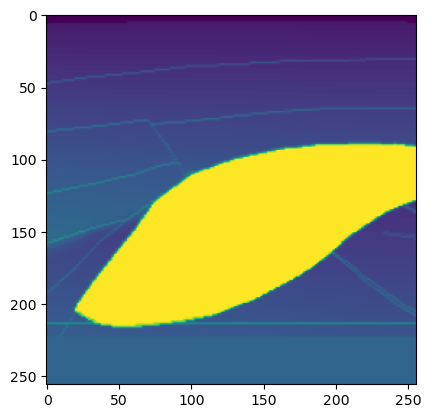

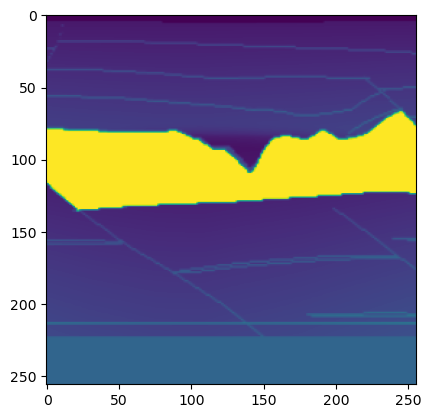

In [163]:
# Inference
image_retrieval_function(
    sample, 10, bert_data, bert_model, 
    text_projector, image_embeddings_list_train, 
    clip_trainset, display=True
)

In [ ]:
del iter